In [26]:
#---- to do list -----
# err_data_list 파일자동화
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from tensorflow.python.keras.optimizer_v2.rmsprop import RMSProp
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv, DataFrame, concat
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, RepeatVector, LSTM, Input, TimeDistributed, Activation, Dropout
from keras.optimizers import SGD
np.set_printoptions(suppress=True)

#pow 낮값만 추출 test
#pow = 0인 구간 : 0~4, 21-23시
powhr_start = 0
powhr_end   = 23

shift_days  = 3
#hoursteps   = powhr_end-powhr_start+1 #(16)
hoursteps   = 48
timesteps   = shift_days*hoursteps #hours step

data_dim    = 15
out_dim     = 1
n_model     = 10
facltyCapacty = 200000

load_path = 'C:/solar/pow_24/'
save_path = 'C:/Users/VISLAB_PHY/Desktop/D_WORKSPACE/Data/'
save_name = '210504_24'

date_start = '10100901'
date_end   = '30191201'

err_date_list = ['20190912','20191122','20191130','20191217','20200501',
                 '20200502','20191028','20191107','20191108','20191109',
                 '20191110','20191111','20191112','20200214','20200307',
                 '20200308','20200309','20200310','20200328','20200329',
                 '20200625','20200809','20201003','20201029','20201226','20201227','20201228','20201229']

# Yeo-JohnsonTransformer

In [27]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer 

transf_type = 'yeo-johnson'
#transf_type = 'box-cox'

def yeo_johnson_transform(dataset):
    
    column_trans = ColumnTransformer(
                    [('sunshine', PowerTransformer(method=transf_type, standardize=True), ['sunshine']),
                     ('humdt', PowerTransformer(method=transf_type, standardize=True), ['humdt']),
                     ('wnd_spd', PowerTransformer(method=transf_type, standardize=True), ['wnd_spd']),
                     ('visiblt', PowerTransformer(method=transf_type, standardize=True), ['visiblt']),
                     ('cloud2', PowerTransformer(method=transf_type, standardize=True), ['cloud2']),
                     ('cloud', PowerTransformer(method=transf_type, standardize=True), ['cloud']),
                     ('grd_temprt', PowerTransformer(method=transf_type, standardize=True), ['grd_temprt']),
                     ('wnd_dir', PowerTransformer(method=transf_type, standardize=True), ['wnd_dir']),
                     ('dewpnt', PowerTransformer(method=transf_type, standardize=True), ['dewpnt']),
                     ('steampressr', PowerTransformer(method=transf_type, standardize=True), ['steampressr']),
                     ('temprt', PowerTransformer(method=transf_type, standardize=True), ['temprt']),
                     ('mincloud', PowerTransformer(method=transf_type, standardize=True), ['mincloud']),
                     ('rain', PowerTransformer(method=transf_type, standardize=True), ['rain']),
                     ('pressr', PowerTransformer(method=transf_type, standardize=True), ['pressr']),
                     ('seapressr', PowerTransformer(method=transf_type, standardize=True), ['seapressr']),
                     ('snow', PowerTransformer(method=transf_type, standardize=True), ['snow'])
                    ])
    
    transformed_data = column_trans.fit_transform(dataset)
    transformed_df = pd.DataFrame(transformed_data, columns=dataset.columns)
    pd.concat([transformed_df], axis = 1)
                    
    return transformed_df

# Get weather, pow data

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import fnmatch
from pandas import read_csv
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer 
#from feature_engine import variable_transformers as vt
from scipy.stats import yeojohnson


#############################################
# 태양광 전력
#############################################
def get_pow():

    # pow 파일 load
    dir_path = 'C:/solar/pow_24/UR00000126_csv'
    file_list   = os.listdir(dir_path)
    print(len(file_list))
    hrPow  = []    

    # pow측정값 에러가 큰 일자 제거
    for filename in file_list:
        if (filename[:-4] not in err_date_list):
            if ((filename[:-4]>=date_start) & (filename<date_end)):
                filedata = pd.read_csv(dir_path+'/'+filename).values[:,0]
                hrPow.append(filedata)
                #print(filename[:-4])

    
    #낮시간 추출 (5~20시)
    pow_dataset = pd.DataFrame(hrPow)
    pow_dataset[23] = 0# 23시 data 쌓이지 않으므로 0으로 채움
    pow_dataset =pow_dataset.iloc[:,powhr_start:powhr_end+1]
    pow_dataset.to_csv(save_path+"/pow_test_"+save_name+".csv",mode='w',index=False)

    # 결측값 보간, reshape
    pow_dataset = pow_dataset.interpolate(method='linear')
    pow_dataset = pow_dataset.values.reshape(-1,1)
    pow_dataset = pd.DataFrame(pow_dataset)
    pow_dataset.columns = ['pow']
    pow_dataset.to_csv(save_path+"/pow_"+save_name+".csv",mode='w',index=False)

    
    # scale
    sc_pow = MinMaxScaler(feature_range = (0, 1))
    scaled_pow = sc_pow.fit_transform(pow_dataset.values)
    df_pow = pd.DataFrame(scaled_pow, columns=pow_dataset.columns, index=list(pow_dataset.index.values))
    
    return df_pow, sc_pow

#############################################
# 종관기상관측
#############################################
def get_weather():
    # pow 파일 load
    file_list   = os.listdir(load_path)
    print(len(file_list))
    for filename in os.listdir(load_path):
        if fnmatch.fnmatch(filename, 'OBS_ASOS_TIM_*.csv'):
            print(filename)

            # load csv data
            dataset = read_csv(load_path+'/'+filename, encoding='CP949')
            dataset.drop(['지점','지점명'], axis=1, inplace=True)
            dataset.drop(['기온 QC플래그','강수량 QC플래그','풍속 QC플래그','풍향 QC플래그','습도 QC플래그'], axis=1, inplace=True)
            dataset.drop(['현지기압 QC플래그','해면기압 QC플래그','일조 QC플래그','지면온도 QC플래그'], axis=1, inplace=True)
            dataset.drop(['5cm 지중온도(°C)','10cm 지중온도(°C)','20cm 지중온도(°C)','30cm 지중온도(°C)'], axis=1, inplace=True)
            dataset.drop(['3시간신적설(cm)','일사(MJ/m2)','운형(운형약어)','지면상태(지면상태코드)','현상번호(국내식)'], axis=1, inplace=True)

            # set column name
            dataset.columns = ['ymdhms', 'temprt', 'rain', 'wnd_spd', 'wnd_dir', 'humdt','steampressr',
                               'dewpnt', 'pressr','seapressr','sunshine','snow','cloud','cloud2','mincloud','visiblt','grd_temprt']

            # prioirty sort (피어슨상관계수)
            dataset = dataset[['ymdhms','sunshine','humdt','wnd_spd','visiblt','cloud2',
                               'cloud','grd_temprt','wnd_dir','dewpnt','steampressr','temprt',
                               'mincloud','rain','pressr','seapressr','snow']]


            # set NA data (관측값 0이 누적되어 결측된 경우. 0으로 세팅)
            dataset['rain'].fillna(0, inplace=True)     #강수량
            dataset['sunshine'].fillna(0, inplace=True) #일조
            dataset['snow'].fillna(0, inplace=True)     #적설량

            #일시 패턴 변환(2019-08-20 5:00 -> 2019082005)
            dataset['ymdhms'] = dataset['ymdhms'].str[0:4]+dataset['ymdhms'].str[5:7]+dataset['ymdhms'].str[8:10]+dataset['ymdhms'].str[-5:-4].replace(" ","0")+dataset['ymdhms'].str[-4:-3]
            # pow측정값 중 결측값 많은 일자 제거
            dataset = dataset[(dataset['ymdhms'].str[0:8]>=date_start) & (dataset['ymdhms'].str[0:8]<date_end)]
            for err_date in err_date_list:
                idx_err = dataset[dataset['ymdhms'].str.startswith(err_date)].index
                dataset = dataset.drop(idx_err)

            #낮시간 추출 (5~20시)
            dataset = dataset[(dataset['ymdhms'].str[-2:]>=str(powhr_start).rjust(2, '0')) &(dataset['ymdhms'].str[-2:]<=str(powhr_end))]
            dataset = dataset.interpolate(method='linear')# 결측값 보간
            
            # save file (test용)
            dataset.to_csv(save_path+"/weather_"+save_name+".csv",mode='w',index=False)

            # normalization
            dataset.drop(['ymdhms'], axis=1, inplace=True)
            dataset = dataset.astype('float32')
            dataset = dataset.interpolate(method='linear')
            
            #YEO-JOHNSON transform
            #yeo_df = yeo_johnson_transform(dataset)
            yeo_df = dataset
            #insert feature (test)
            yeo_df.insert(2, 'temp_press', yeo_df['temprt']-yeo_df['steampressr'], True)
            yeo_df.insert(2, 'sunshine_humdt', abs(yeo_df['sunshine'])-(yeo_df['humdt']*(2.1)), True)#0.35
            
            sc = MinMaxScaler(feature_range = (0, 1))#scale
            scaled_weather = sc.fit_transform(yeo_df.values)
            weather = pd.DataFrame(scaled_weather, columns=yeo_df.columns, index=list(yeo_df.index.values))
            
            weather = weather.iloc[:, 0:data_dim] #feature size 조절
            
    return weather


# Numpy data
weather, pow

In [29]:
#############################################
# numpy data 만들기
#############################################

df_pow, sc_pow   = get_pow()
df               = get_weather()

print("df_pow : ", df_pow.shape)
print("df : ",df.shape)

# pow + weather + powY
df.insert(0, 'pow', df_pow.values, True)
df = df.iloc[0:-timesteps, :]
df.insert(df.shape[1], 'pow_Y', df_pow.iloc[timesteps:, :].values, True)

df.to_csv(save_path+"/total_"+save_name+".csv",mode='w',index=False, encoding='CP949')


550
13
OBS_ASOS_TIM_20190820_20210313.csv
df_pow :  (13056, 1)
df :  (13056, 15)


In [ ]:
print()

In [30]:
 df.corr(method='pearson')

,pow,sunshine,humdt,sunshine_humdt,temp_press,wnd_spd,visiblt,cloud2,cloud,grd_temprt,wnd_dir,dewpnt,steampressr,temprt,mincloud,rain,pow_Y
pow,1.000000,0.747989,-0.529130,0.532603,0.531586,0.360453,0.311135,-0.241311,-0.222506,0.294830,0.239090,-0.124818,-0.122677,0.157984,0.100392,-0.074434,0.734516
sunshine,0.747989,1.000000,-0.650352,0.655316,0.627875,0.386597,0.388167,-0.386269,-0.346704,0.286624,0.282305,-0.164148,-0.156870,0.176023,0.143972,-0.089176,0.514305
humdt,-0.529130,-0.650352,1.000000,-0.999979,-0.674020,-0.581695,-0.670928,0.361374,0.312210,0.018611,-0.533241,0.545488,0.494528,0.099177,-0.273289,0.152772,-0.372976
sunshine_humdt,0.532603,0.655316,-0.999979,1.000000,0.675641,0.581754,0.670498,-0.362671,-0.313443,-0.016033,0.532673,-0.543832,-0.493096,-0.097100,0.272991,-0.152681,0.375312
temp_press,0.531586,0.627875,-0.674020,0.675641,1.000000,0.322161,0.401381,-0.182568,-0.101603,0.508140,0.294924,0.065621,-0.035755,0.469492,0.222730,-0.087811,0.413112
wnd_spd,0.360453,0.386597,-0.581695,0.581754,0.322161,1.000000,0.432112,-0.099605,-0.103488,-0.031025,0.692556,-0.320500,-0.270759,-0.077787,-0.071635,0.040979,0.286644
visiblt,0.311135,0.388167,-0.670928,0.670498,0.401381,0.432112,1.000000,-0.226679,-0.189121,-0.024003,0.438477,-0.371825,-0.334169,-0.094114,0.163699,-0.176523,0.217832
cloud2,-0.241311,-0.386269,0.361374,-0.362671,-0.182568,-0.099605,-0.226679,1.000000,0.675451,0.124574,-0.123194,0.317869,0.298814,0.172521,-0.254658,0.139304,-0.060885
cloud,-0.222506,-0.346704,0.312210,-0.313443,-0.101603,-0.103488,-0.189121,0.675451,1.000000,0.123123,-0.110257,0.286304,0.239598,0.160774,-0.100259,0.114800,-0.019450
grd_temprt,0.294830,0.286624,0.018611,-0.016033,0.508140,-0.031025,-0.024003,0.124574,0.123123,1.000000,-0.069807,0.799846,0.788631,0.951377,-0.146154,0.090533,0.250409


In [5]:
#dir_path = 'C:/Users/VISLAB_PHY/Desktop/D_WORKSPACE/Data/'
#df = read_csv(dir_path+'total.csv', encoding='CP949')
#----------------------------------------------
# time step만큼 window 움직여 dataset 생성
#----------------------------------------------
totalsize = df.shape[0]
dataX, dataY = [], []

for i in range(0, totalsize-timesteps-24+1, hoursteps):
    dataX.append(df.iloc[i:(i + timesteps),0:-1])
    dataY.append(df.iloc[i:(i + hoursteps),[0]])

print("len(dataX) : ", len(dataX), dataX[0].shape)
print("len(dataY) : ", len(dataY), dataY[0].shape)

#----------------------------------------------
#  Split train/test 
#----------------------------------------------

train_size = int(len(dataX) * 0.7)
val_size   = int(len(dataX) * 0.2)
test_size  = len(dataX) - train_size - val_size
val_idx = train_size+val_size

trainX, valX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:val_idx]), np.array(dataX[val_idx:val_idx+test_size])
trainY, valY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:val_idx]), np.array(dataY[val_idx:val_idx+test_size])

print('train X : ', trainX.shape, '\tY : ', trainY.shape)
print('val   X : ', valX.shape,   '\tY : ', valY.shape)
print('test  X : ', testX.shape,  '\tY : ', testY.shape)

np.save("npset/"+save_name+"_trainX",trainX)
np.save("npset/"+save_name+"_trainY",trainY)
np.save("npset/"+save_name+"_valX",valX)
np.save("npset/"+save_name+"_valY",valY)
np.save("npset/"+save_name+"_testX",testX)
np.save("npset/"+save_name+"_testY",testY)


# 모델 1

len(dataX) :  266 (144, 16)
len(dataY) :  266 (48, 1)
train X :  (186, 144, 16) 	Y :  (186, 48, 1)
val   X :  (53, 144, 16) 	Y :  (53, 48, 1)
test  X :  (27, 144, 16) 	Y :  (27, 48, 1)


In [6]:
import tensorflow as tf

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(256, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(tf.keras.layers.RepeatVector(hoursteps))
model.add(tf.keras.layers.LSTM(256, return_sequences=True))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(256, activation='relu')))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1)))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               279552    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 48, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 48, 256)           525312    
_________________________________________________________________
time_distributed (TimeDistri (None, 48, 256)           65792     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 48, 1)             257       
Total params: 870,913
Trainable params: 870,913
Non-trainable params: 0
_________________________________________________________________


# 모델 fit 반복돌리기
range 바꾸기

In [7]:
for i in range(n_model):#0,5):#

    #keras.optimizers.RMSprop(lr=0.005, rho=0.9, epsilon=None, decay=0.0)
    model.compile(loss='mean_squared_error', 
                  optimizer=RMSProp()
                  #optimizer=RMSProp(learning_rate=0.001)
                  #optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True), 
                  #metrics=['acc'])
                 )

    hist = model.fit(trainX, 
                     trainY, 
                     epochs=200, 
                     batch_size=128,
                     validation_data=(valX, valY))


    results = model.evaluate(testX, testY)
    #model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

    model.save('model/model_'+save_name+'_'+str(i)+'.h5')# # of feature=3,5,7,9,?,12,14,16,18

Train on 186 samples, validate on 53 samples
Epoch 1/200
186/186 [==============================] - 4s 24ms/sample - loss: 0.2616 - val_loss: 0.0898
Epoch 2/200
186/186 [==============================] - 0s 295us/sample - loss: 0.0897 - val_loss: 0.0199
Epoch 3/200
186/186 [==============================] - 0s 290us/sample - loss: 0.0302 - val_loss: 0.0174
Epoch 4/200
186/186 [==============================] - 0s 300us/sample - loss: 0.0268 - val_loss: 0.0173
Epoch 5/200
186/186 [==============================] - 0s 295us/sample - loss: 0.0261 - val_loss: 0.0174
Epoch 6/200
186/186 [==============================] - 0s 295us/sample - loss: 0.0260 - val_loss: 0.0189
Epoch 7/200
186/186 [==============================] - 0s 295us/sample - loss: 0.0265 - val_loss: 0.0181
Epoch 8/200
186/186 [==============================] - 0s 279us/sample - loss: 0.0265 - val_loss: 0.0184
Epoch 9/200
186/186 [==============================] - 0s 268us/sample - loss: 0.0269 - val_loss: 0.0183
Epoch 10/20

Epoch 78/200
186/186 [==============================] - 0s 268us/sample - loss: 0.0131 - val_loss: 0.0083
Epoch 79/200
186/186 [==============================] - 0s 268us/sample - loss: 0.0161 - val_loss: 0.0152
Epoch 80/200
186/186 [==============================] - 0s 268us/sample - loss: 0.0230 - val_loss: 0.0073
Epoch 81/200
186/186 [==============================] - 0s 273us/sample - loss: 0.0167 - val_loss: 0.0134
Epoch 82/200
186/186 [==============================] - 0s 279us/sample - loss: 0.0203 - val_loss: 0.0139
Epoch 83/200
186/186 [==============================] - 0s 273us/sample - loss: 0.0214 - val_loss: 0.0115
Epoch 84/200
186/186 [==============================] - 0s 268us/sample - loss: 0.0171 - val_loss: 0.0057
Epoch 85/200
186/186 [==============================] - 0s 268us/sample - loss: 0.0118 - val_loss: 0.0088
Epoch 86/200
186/186 [==============================] - 0s 268us/sample - loss: 0.0164 - val_loss: 0.0139
Epoch 87/200
186/186 [========================

Epoch 155/200
186/186 [==============================] - 0s 271us/sample - loss: 0.0122 - val_loss: 0.0072
Epoch 156/200
186/186 [==============================] - ETA: 0s - loss: 0.010 - 0s 279us/sample - loss: 0.0109 - val_loss: 0.0119
Epoch 157/200
186/186 [==============================] - 0s 280us/sample - loss: 0.0148 - val_loss: 0.0097
Epoch 158/200
186/186 [==============================] - 0s 273us/sample - loss: 0.0147 - val_loss: 0.0076
Epoch 159/200
186/186 [==============================] - 0s 274us/sample - loss: 0.0102 - val_loss: 0.0071
Epoch 160/200
186/186 [==============================] - 0s 268us/sample - loss: 0.0100 - val_loss: 0.0104
Epoch 161/200
186/186 [==============================] - 0s 263us/sample - loss: 0.0132 - val_loss: 0.0068
Epoch 162/200
186/186 [==============================] - 0s 268us/sample - loss: 0.0100 - val_loss: 0.0093
Epoch 163/200
186/186 [==============================] - 0s 263us/sample - loss: 0.0114 - val_loss: 0.0076
Epoch 164/200

186/186 [==============================] - 0s 268us/sample - loss: 0.0087 - val_loss: 0.0095
Epoch 24/200
186/186 [==============================] - 0s 279us/sample - loss: 0.0124 - val_loss: 0.0083
Epoch 25/200
186/186 [==============================] - 0s 271us/sample - loss: 0.0100 - val_loss: 0.0069
Epoch 26/200
186/186 [==============================] - 0s 268us/sample - loss: 0.0086 - val_loss: 0.0062
Epoch 27/200
186/186 [==============================] - 0s 272us/sample - loss: 0.0085 - val_loss: 0.0077
Epoch 28/200
186/186 [==============================] - 0s 269us/sample - loss: 0.0099 - val_loss: 0.0056
Epoch 29/200
186/186 [==============================] - 0s 283us/sample - loss: 0.0069 - val_loss: 0.0059
Epoch 30/200
186/186 [==============================] - 0s 279us/sample - loss: 0.0082 - val_loss: 0.0092
Epoch 31/200
186/186 [==============================] - 0s 279us/sample - loss: 0.0117 - val_loss: 0.0051
Epoch 32/200
186/186 [==============================] - 0s 

186/186 [==============================] - 0s 268us/sample - loss: 0.0054 - val_loss: 0.0076
Epoch 101/200
186/186 [==============================] - 0s 269us/sample - loss: 0.0109 - val_loss: 0.0085
Epoch 102/200
186/186 [==============================] - 0s 266us/sample - loss: 0.0113 - val_loss: 0.0073
Epoch 103/200
186/186 [==============================] - 0s 268us/sample - loss: 0.0085 - val_loss: 0.0066
Epoch 104/200
186/186 [==============================] - 0s 284us/sample - loss: 0.0069 - val_loss: 0.0072
Epoch 105/200
186/186 [==============================] - 0s 279us/sample - loss: 0.0070 - val_loss: 0.0072
Epoch 106/200
186/186 [==============================] - 0s 268us/sample - loss: 0.0062 - val_loss: 0.0058
Epoch 107/200
186/186 [==============================] - 0s 268us/sample - loss: 0.0059 - val_loss: 0.0073
Epoch 108/200
186/186 [==============================] - 0s 273us/sample - loss: 0.0074 - val_loss: 0.0058
Epoch 109/200
186/186 [============================

186/186 [==============================] - 0s 266us/sample - loss: 0.0068 - val_loss: 0.0053
Epoch 177/200
186/186 [==============================] - 0s 263us/sample - loss: 0.0075 - val_loss: 0.0074
Epoch 178/200
186/186 [==============================] - 0s 273us/sample - loss: 0.0074 - val_loss: 0.0064
Epoch 179/200
186/186 [==============================] - 0s 268us/sample - loss: 0.0062 - val_loss: 0.0076
Epoch 180/200
186/186 [==============================] - 0s 270us/sample - loss: 0.0058 - val_loss: 0.0058
Epoch 181/200
186/186 [==============================] - 0s 274us/sample - loss: 0.0052 - val_loss: 0.0070
Epoch 182/200
186/186 [==============================] - 0s 268us/sample - loss: 0.0056 - val_loss: 0.0066
Epoch 183/200
186/186 [==============================] - 0s 263us/sample - loss: 0.0053 - val_loss: 0.0082
Epoch 184/200
186/186 [==============================] - 0s 268us/sample - loss: 0.0063 - val_loss: 0.0062
Epoch 185/200
186/186 [============================

Epoch 45/200
186/186 [==============================] - 0s 279us/sample - loss: 0.0043 - val_loss: 0.0095
Epoch 46/200
186/186 [==============================] - 0s 279us/sample - loss: 0.0077 - val_loss: 0.0061
Epoch 47/200
186/186 [==============================] - 0s 268us/sample - loss: 0.0050 - val_loss: 0.0062
Epoch 48/200
186/186 [==============================] - 0s 268us/sample - loss: 0.0036 - val_loss: 0.0064
Epoch 49/200
186/186 [==============================] - 0s 269us/sample - loss: 0.0035 - val_loss: 0.0074
Epoch 50/200
186/186 [==============================] - 0s 257us/sample - loss: 0.0043 - val_loss: 0.0084
Epoch 51/200
186/186 [==============================] - 0s 274us/sample - loss: 0.0053 - val_loss: 0.0073
Epoch 52/200
186/186 [==============================] - 0s 279us/sample - loss: 0.0047 - val_loss: 0.0064
Epoch 53/200
186/186 [==============================] - 0s 279us/sample - loss: 0.0045 - val_loss: 0.0063
Epoch 54/200
186/186 [========================

186/186 [==============================] - 0s 269us/sample - loss: 0.0042 - val_loss: 0.0058
Epoch 123/200
186/186 [==============================] - 0s 272us/sample - loss: 0.0041 - val_loss: 0.0074
Epoch 124/200
186/186 [==============================] - 0s 278us/sample - loss: 0.0044 - val_loss: 0.0069
Epoch 125/200
186/186 [==============================] - 0s 279us/sample - loss: 0.0027 - val_loss: 0.0059
Epoch 126/200
186/186 [==============================] - 0s 266us/sample - loss: 0.0024 - val_loss: 0.0053
Epoch 127/200
186/186 [==============================] - 0s 266us/sample - loss: 0.0020 - val_loss: 0.0069
Epoch 128/200
186/186 [==============================] - 0s 268us/sample - loss: 0.0033 - val_loss: 0.0069
Epoch 129/200
186/186 [==============================] - 0s 274us/sample - loss: 0.0039 - val_loss: 0.0081
Epoch 130/200
186/186 [==============================] - 0s 268us/sample - loss: 0.0051 - val_loss: 0.0055
Epoch 131/200
186/186 [============================

186/186 [==============================] - 0s 269us/sample - loss: 0.0027 - val_loss: 0.0068
Epoch 199/200
186/186 [==============================] - 0s 269us/sample - loss: 0.0032 - val_loss: 0.0060
Epoch 200/200
27/1 [============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

186/186 [==============================] - 0s 284us/sample - loss: 0.0029 - val_loss: 0.0078
Epoch 68/200
186/186 [==============================] - 0s 274us/sample - loss: 0.0034 - val_loss: 0.0072
Epoch 69/200
186/186 [==============================] - 0s 273us/sample - loss: 0.0021 - val_loss: 0.0068
Epoch 70/200
186/186 [==============================] - 0s 273us/sample - loss: 0.0016 - val_loss: 0.0076
Epoch 71/200
186/186 [==============================] - 0s 277us/sample - loss: 0.0028 - val_loss: 0.0067
Epoch 72/200
186/186 [==============================] - 0s 279us/sample - loss: 0.0024 - val_loss: 0.0084
Epoch 73/200
186/186 [==============================] - 0s 268us/sample - loss: 0.0024 - val_loss: 0.0069
Epoch 74/200
186/186 [==============================] - 0s 276us/sample - loss: 0.0019 - val_loss: 0.0068
Epoch 75/200
186/186 [==============================] - 0s 274us/sample - loss: 0.0021 - val_loss: 0.0063
Epoch 76/200
186/186 [==============================] - 0s 

Epoch 144/200
186/186 [==============================] - 0s 277us/sample - loss: 0.0026 - val_loss: 0.0066
Epoch 145/200
186/186 [==============================] - 0s 274us/sample - loss: 0.0027 - val_loss: 0.0069
Epoch 146/200
186/186 [==============================] - 0s 273us/sample - loss: 0.0023 - val_loss: 0.0065
Epoch 147/200
186/186 [==============================] - 0s 269us/sample - loss: 0.0028 - val_loss: 0.0092
Epoch 148/200
186/186 [==============================] - 0s 274us/sample - loss: 0.0024 - val_loss: 0.0070
Epoch 149/200
186/186 [==============================] - 0s 273us/sample - loss: 0.0017 - val_loss: 0.0083
Epoch 150/200
186/186 [==============================] - 0s 273us/sample - loss: 0.0028 - val_loss: 0.0065
Epoch 151/200
186/186 [==============================] - 0s 264us/sample - loss: 0.0015 - val_loss: 0.0064
Epoch 152/200
186/186 [==============================] - 0s 268us/sample - loss: 0.0011 - val_loss: 0.0071
Epoch 153/200
186/186 [==============

186/186 [==============================] - 0s 267us/sample - loss: 0.0015 - val_loss: 0.0064
Epoch 13/200
186/186 [==============================] - 0s 283us/sample - loss: 0.0020 - val_loss: 0.0060
Epoch 14/200
186/186 [==============================] - 0s 274us/sample - loss: 0.0015 - val_loss: 0.0059
Epoch 15/200
186/186 [==============================] - 0s 285us/sample - loss: 0.0018 - val_loss: 0.0068
Epoch 16/200
186/186 [==============================] - 0s 275us/sample - loss: 0.0024 - val_loss: 0.0078
Epoch 17/200
186/186 [==============================] - 0s 280us/sample - loss: 0.0033 - val_loss: 0.0071
Epoch 18/200
186/186 [==============================] - 0s 279us/sample - loss: 0.0032 - val_loss: 0.0059
Epoch 19/200
186/186 [==============================] - 0s 275us/sample - loss: 0.0017 - val_loss: 0.0064
Epoch 20/200
186/186 [==============================] - 0s 279us/sample - loss: 0.0014 - val_loss: 0.0064
Epoch 21/200
186/186 [==============================] - 0s 

186/186 [==============================] - 0s 274us/sample - loss: 0.0012 - val_loss: 0.0059
Epoch 90/200
186/186 [==============================] - 0s 269us/sample - loss: 8.9757e-04 - val_loss: 0.0064
Epoch 91/200
186/186 [==============================] - 0s 279us/sample - loss: 0.0013 - val_loss: 0.0074
Epoch 92/200
186/186 [==============================] - 0s 268us/sample - loss: 0.0025 - val_loss: 0.0079
Epoch 93/200
186/186 [==============================] - 0s 273us/sample - loss: 0.0025 - val_loss: 0.0070
Epoch 94/200
186/186 [==============================] - 0s 279us/sample - loss: 0.0022 - val_loss: 0.0072
Epoch 95/200
186/186 [==============================] - 0s 273us/sample - loss: 0.0019 - val_loss: 0.0072
Epoch 96/200
186/186 [==============================] - 0s 268us/sample - loss: 0.0019 - val_loss: 0.0070
Epoch 97/200
186/186 [==============================] - 0s 273us/sample - loss: 0.0019 - val_loss: 0.0061
Epoch 98/200
186/186 [==============================] -

186/186 [==============================] - 0s 274us/sample - loss: 0.0012 - val_loss: 0.0072
Epoch 166/200
186/186 [==============================] - 0s 268us/sample - loss: 0.0013 - val_loss: 0.0073
Epoch 167/200
186/186 [==============================] - 0s 271us/sample - loss: 0.0014 - val_loss: 0.0072
Epoch 168/200
186/186 [==============================] - 0s 275us/sample - loss: 0.0020 - val_loss: 0.0071
Epoch 169/200
186/186 [==============================] - 0s 277us/sample - loss: 0.0021 - val_loss: 0.0065
Epoch 170/200
186/186 [==============================] - 0s 279us/sample - loss: 0.0012 - val_loss: 0.0061
Epoch 171/200
186/186 [==============================] - 0s 280us/sample - loss: 9.7762e-04 - val_loss: 0.0068
Epoch 172/200
186/186 [==============================] - 0s 269us/sample - loss: 0.0015 - val_loss: 0.0082
Epoch 173/200
186/186 [==============================] - 0s 267us/sample - loss: 0.0028 - val_loss: 0.0073
Epoch 174/200
186/186 [========================

186/186 [==============================] - 0s 290us/sample - loss: 0.0014 - val_loss: 0.0070
Epoch 34/200
186/186 [==============================] - 0s 284us/sample - loss: 0.0015 - val_loss: 0.0079
Epoch 35/200
186/186 [==============================] - 0s 273us/sample - loss: 0.0025 - val_loss: 0.0072
Epoch 36/200
186/186 [==============================] - 0s 272us/sample - loss: 0.0018 - val_loss: 0.0064
Epoch 37/200
186/186 [==============================] - 0s 275us/sample - loss: 0.0013 - val_loss: 0.0064
Epoch 38/200
186/186 [==============================] - 0s 279us/sample - loss: 0.0013 - val_loss: 0.0061
Epoch 39/200
186/186 [==============================] - 0s 284us/sample - loss: 9.7344e-04 - val_loss: 0.0068
Epoch 40/200
186/186 [==============================] - 0s 283us/sample - loss: 9.8091e-04 - val_loss: 0.0069
Epoch 41/200
186/186 [==============================] - 0s 279us/sample - loss: 0.0014 - val_loss: 0.0079
Epoch 42/200
186/186 [=============================

Epoch 110/200
186/186 [==============================] - 0s 268us/sample - loss: 0.0013 - val_loss: 0.0098
Epoch 111/200
186/186 [==============================] - 0s 275us/sample - loss: 0.0032 - val_loss: 0.0066
Epoch 112/200
186/186 [==============================] - 0s 273us/sample - loss: 0.0014 - val_loss: 0.0063
Epoch 113/200
186/186 [==============================] - 0s 279us/sample - loss: 7.3365e-04 - val_loss: 0.0058
Epoch 114/200
186/186 [==============================] - 0s 278us/sample - loss: 5.9090e-04 - val_loss: 0.0060
Epoch 115/200
186/186 [==============================] - 0s 274us/sample - loss: 5.7686e-04 - val_loss: 0.0065
Epoch 116/200
186/186 [==============================] - 0s 273us/sample - loss: 7.6398e-04 - val_loss: 0.0070
Epoch 117/200
186/186 [==============================] - 0s 273us/sample - loss: 0.0021 - val_loss: 0.0081
Epoch 118/200
186/186 [==============================] - 0s 273us/sample - loss: 0.0030 - val_loss: 0.0081
Epoch 119/200
186/186

186/186 [==============================] - 0s 280us/sample - loss: 0.0021 - val_loss: 0.0058
Epoch 186/200
186/186 [==============================] - 0s 270us/sample - loss: 0.0012 - val_loss: 0.0057
Epoch 187/200
186/186 [==============================] - 0s 273us/sample - loss: 9.5532e-04 - val_loss: 0.0057
Epoch 188/200
186/186 [==============================] - 0s 279us/sample - loss: 0.0012 - val_loss: 0.0059
Epoch 189/200
186/186 [==============================] - 0s 276us/sample - loss: 0.0016 - val_loss: 0.0066
Epoch 190/200
186/186 [==============================] - 0s 273us/sample - loss: 0.0018 - val_loss: 0.0059
Epoch 191/200
186/186 [==============================] - 0s 270us/sample - loss: 0.0013 - val_loss: 0.0065
Epoch 192/200
186/186 [==============================] - 0s 274us/sample - loss: 9.1281e-04 - val_loss: 0.0061
Epoch 193/200
186/186 [==============================] - 0s 274us/sample - loss: 8.3659e-04 - val_loss: 0.0056
Epoch 194/200
186/186 [================

186/186 [==============================] - 0s 273us/sample - loss: 8.5476e-04 - val_loss: 0.0066
Epoch 54/200
186/186 [==============================] - 0s 279us/sample - loss: 9.6378e-04 - val_loss: 0.0067
Epoch 55/200
186/186 [==============================] - 0s 271us/sample - loss: 0.0015 - val_loss: 0.0069
Epoch 56/200
186/186 [==============================] - 0s 274us/sample - loss: 0.0017 - val_loss: 0.0068
Epoch 57/200
186/186 [==============================] - 0s 268us/sample - loss: 9.3148e-04 - val_loss: 0.0061
Epoch 58/200
186/186 [==============================] - 0s 274us/sample - loss: 7.9565e-04 - val_loss: 0.0057
Epoch 59/200
186/186 [==============================] - 0s 285us/sample - loss: 9.8593e-04 - val_loss: 0.0062
Epoch 60/200
186/186 [==============================] - 0s 279us/sample - loss: 0.0012 - val_loss: 0.0068
Epoch 61/200
186/186 [==============================] - 0s 278us/sample - loss: 0.0023 - val_loss: 0.0062
Epoch 62/200
186/186 [=================

186/186 [==============================] - 0s 268us/sample - loss: 0.0013 - val_loss: 0.0057
Epoch 130/200
186/186 [==============================] - 0s 278us/sample - loss: 9.5158e-04 - val_loss: 0.0059
Epoch 131/200
186/186 [==============================] - 0s 279us/sample - loss: 8.5046e-04 - val_loss: 0.0064
Epoch 132/200
186/186 [==============================] - 0s 278us/sample - loss: 0.0011 - val_loss: 0.0065
Epoch 133/200
186/186 [==============================] - 0s 271us/sample - loss: 0.0011 - val_loss: 0.0056
Epoch 134/200
186/186 [==============================] - 0s 274us/sample - loss: 0.0011 - val_loss: 0.0053
Epoch 135/200
186/186 [==============================] - 0s 279us/sample - loss: 9.7564e-04 - val_loss: 0.0061
Epoch 136/200
186/186 [==============================] - 0s 279us/sample - loss: 0.0017 - val_loss: 0.0066
Epoch 137/200
186/186 [==============================] - 0s 273us/sample - loss: 0.0017 - val_loss: 0.0057
Epoch 138/200
186/186 [================

Train on 186 samples, validate on 53 samples
Epoch 1/200
186/186 [==============================] - 3s 18ms/sample - loss: 0.0043 - val_loss: 0.0087
Epoch 2/200
186/186 [==============================] - 0s 316us/sample - loss: 0.0066 - val_loss: 0.0059
Epoch 3/200
186/186 [==============================] - 0s 300us/sample - loss: 0.0014 - val_loss: 0.0058
Epoch 4/200
186/186 [==============================] - 0s 304us/sample - loss: 9.3475e-04 - val_loss: 0.0060
Epoch 5/200
186/186 [==============================] - 0s 301us/sample - loss: 8.0767e-04 - val_loss: 0.0069
Epoch 6/200
186/186 [==============================] - 0s 295us/sample - loss: 0.0018 - val_loss: 0.0068
Epoch 7/200
186/186 [==============================] - 0s 284us/sample - loss: 9.3534e-04 - val_loss: 0.0064
Epoch 8/200
186/186 [==============================] - 0s 280us/sample - loss: 8.8173e-04 - val_loss: 0.0068
Epoch 9/200
186/186 [==============================] - 0s 279us/sample - loss: 0.0011 - val_loss: 0.

Epoch 77/200
186/186 [==============================] - 0s 271us/sample - loss: 0.0015 - val_loss: 0.0060
Epoch 78/200
186/186 [==============================] - 0s 270us/sample - loss: 0.0014 - val_loss: 0.0056
Epoch 79/200
186/186 [==============================] - 0s 274us/sample - loss: 7.7587e-04 - val_loss: 0.0055
Epoch 80/200
186/186 [==============================] - 0s 277us/sample - loss: 6.6042e-04 - val_loss: 0.0056
Epoch 81/200
186/186 [==============================] - 0s 270us/sample - loss: 9.1664e-04 - val_loss: 0.0060
Epoch 82/200
186/186 [==============================] - 0s 272us/sample - loss: 9.8283e-04 - val_loss: 0.0061
Epoch 83/200
186/186 [==============================] - 0s 274us/sample - loss: 8.9504e-04 - val_loss: 0.0061
Epoch 84/200
186/186 [==============================] - ETA: 0s - loss: 9.8656e-0 - 0s 273us/sample - loss: 9.8090e-04 - val_loss: 0.0056
Epoch 85/200
186/186 [==============================] - 0s 273us/sample - loss: 0.0014 - val_loss: 0

Epoch 152/200
186/186 [==============================] - 0s 276us/sample - loss: 0.0013 - val_loss: 0.0058
Epoch 153/200
186/186 [==============================] - 0s 273us/sample - loss: 7.2810e-04 - val_loss: 0.0062
Epoch 154/200
186/186 [==============================] - 0s 272us/sample - loss: 7.8367e-04 - val_loss: 0.0063
Epoch 155/200
186/186 [==============================] - 0s 277us/sample - loss: 8.4742e-04 - val_loss: 0.0060
Epoch 156/200
186/186 [==============================] - 0s 272us/sample - loss: 6.6021e-04 - val_loss: 0.0057
Epoch 157/200
186/186 [==============================] - 0s 284us/sample - loss: 8.4884e-04 - val_loss: 0.0061
Epoch 158/200
186/186 [==============================] - 0s 295us/sample - loss: 0.0013 - val_loss: 0.0065
Epoch 159/200
186/186 [==============================] - 0s 290us/sample - loss: 0.0024 - val_loss: 0.0061
Epoch 160/200
186/186 [==============================] - 0s 279us/sample - loss: 0.0012 - val_loss: 0.0054
Epoch 161/200
186

Epoch 19/200
186/186 [==============================] - 0s 279us/sample - loss: 0.0015 - val_loss: 0.0063
Epoch 20/200
186/186 [==============================] - 0s 274us/sample - loss: 0.0011 - val_loss: 0.0067
Epoch 21/200
186/186 [==============================] - 0s 269us/sample - loss: 8.3170e-04 - val_loss: 0.0067
Epoch 22/200
186/186 [==============================] - 0s 277us/sample - loss: 0.0014 - val_loss: 0.0069
Epoch 23/200
186/186 [==============================] - 0s 272us/sample - loss: 0.0010 - val_loss: 0.0070
Epoch 24/200
186/186 [==============================] - 0s 275us/sample - loss: 0.0012 - val_loss: 0.0068
Epoch 25/200
186/186 [==============================] - 0s 273us/sample - loss: 8.0324e-04 - val_loss: 0.0063
Epoch 26/200
186/186 [==============================] - 0s 293us/sample - loss: 5.9510e-04 - val_loss: 0.0067
Epoch 27/200
186/186 [==============================] - 0s 273us/sample - loss: 0.0010 - val_loss: 0.0072
Epoch 28/200
186/186 [============

Epoch 95/200
186/186 [==============================] - 0s 268us/sample - loss: 6.7037e-04 - val_loss: 0.0056
Epoch 96/200
186/186 [==============================] - 0s 274us/sample - loss: 6.9993e-04 - val_loss: 0.0056
Epoch 97/200
186/186 [==============================] - 0s 266us/sample - loss: 9.4322e-04 - val_loss: 0.0062
Epoch 98/200
186/186 [==============================] - 0s 277us/sample - loss: 0.0013 - val_loss: 0.0055
Epoch 99/200
186/186 [==============================] - 0s 286us/sample - loss: 0.0011 - val_loss: 0.0055
Epoch 100/200
186/186 [==============================] - 0s 268us/sample - loss: 0.0010 - val_loss: 0.0054
Epoch 101/200
186/186 [==============================] - 0s 279us/sample - loss: 0.0011 - val_loss: 0.0059
Epoch 102/200
186/186 [==============================] - 0s 284us/sample - loss: 8.3617e-04 - val_loss: 0.0056
Epoch 103/200
186/186 [==============================] - 0s 273us/sample - loss: 5.7489e-04 - val_loss: 0.0055
Epoch 104/200
186/186 

186/186 [==============================] - 0s 274us/sample - loss: 5.6138e-04 - val_loss: 0.0062
Epoch 170/200
186/186 [==============================] - 0s 268us/sample - loss: 8.4435e-04 - val_loss: 0.0065
Epoch 171/200
186/186 [==============================] - 0s 263us/sample - loss: 9.2556e-04 - val_loss: 0.0063
Epoch 172/200
186/186 [==============================] - 0s 279us/sample - loss: 0.0012 - val_loss: 0.0056
Epoch 173/200
186/186 [==============================] - 0s 268us/sample - loss: 0.0011 - val_loss: 0.0054
Epoch 174/200
186/186 [==============================] - 0s 267us/sample - loss: 0.0014 - val_loss: 0.0060
Epoch 175/200
186/186 [==============================] - 0s 275us/sample - loss: 0.0011 - val_loss: 0.0055
Epoch 176/200
186/186 [==============================] - 0s 279us/sample - loss: 5.4594e-04 - val_loss: 0.0056
Epoch 177/200
186/186 [==============================] - 0s 270us/sample - loss: 4.3520e-04 - val_loss: 0.0055
Epoch 178/200
186/186 [========

186/186 [==============================] - 0s 267us/sample - loss: 5.5658e-04 - val_loss: 0.0062
Epoch 37/200
186/186 [==============================] - 0s 274us/sample - loss: 4.2156e-04 - val_loss: 0.0061
Epoch 38/200
186/186 [==============================] - 0s 279us/sample - loss: 4.3043e-04 - val_loss: 0.0063
Epoch 39/200
186/186 [==============================] - 0s 284us/sample - loss: 8.9659e-04 - val_loss: 0.0068
Epoch 40/200
186/186 [==============================] - 0s 274us/sample - loss: 0.0014 - val_loss: 0.0070
Epoch 41/200
186/186 [==============================] - 0s 273us/sample - loss: 0.0012 - val_loss: 0.0060
Epoch 42/200
186/186 [==============================] - 0s 274us/sample - loss: 8.2565e-04 - val_loss: 0.0067
Epoch 43/200
186/186 [==============================] - 0s 281us/sample - loss: 5.8874e-04 - val_loss: 0.0065
Epoch 44/200
186/186 [==============================] - 0s 279us/sample - loss: 8.1164e-04 - val_loss: 0.0069
Epoch 45/200
186/186 [=========

186/186 [==============================] - 0s 279us/sample - loss: 0.0015 - val_loss: 0.0062
Epoch 112/200
186/186 [==============================] - 0s 284us/sample - loss: 0.0014 - val_loss: 0.0056
Epoch 113/200
186/186 [==============================] - 0s 270us/sample - loss: 9.0770e-04 - val_loss: 0.0055
Epoch 114/200
186/186 [==============================] - 0s 274us/sample - loss: 7.6034e-04 - val_loss: 0.0055
Epoch 115/200
186/186 [==============================] - 0s 272us/sample - loss: 6.5125e-04 - val_loss: 0.0052
Epoch 116/200
186/186 [==============================] - 0s 277us/sample - loss: 4.9706e-04 - val_loss: 0.0054
Epoch 117/200
186/186 [==============================] - 0s 273us/sample - loss: 4.3205e-04 - val_loss: 0.0056
Epoch 118/200
186/186 [==============================] - 0s 279us/sample - loss: 5.9364e-04 - val_loss: 0.0057
Epoch 119/200
186/186 [==============================] - 0s 267us/sample - loss: 7.5029e-04 - val_loss: 0.0059
Epoch 120/200
186/186 [

186/186 [==============================] - 0s 279us/sample - loss: 9.1346e-04 - val_loss: 0.0058
Epoch 186/200
186/186 [==============================] - 0s 275us/sample - loss: 0.0012 - val_loss: 0.0056
Epoch 187/200
186/186 [==============================] - 0s 284us/sample - loss: 7.6636e-04 - val_loss: 0.0055
Epoch 188/200
186/186 [==============================] - 0s 290us/sample - loss: 7.6285e-04 - val_loss: 0.0053
Epoch 189/200
186/186 [==============================] - 0s 290us/sample - loss: 0.0010 - val_loss: 0.0052
Epoch 190/200
186/186 [==============================] - 0s 273us/sample - loss: 6.2772e-04 - val_loss: 0.0056
Epoch 191/200
186/186 [==============================] - 0s 274us/sample - loss: 6.4910e-04 - val_loss: 0.0054
Epoch 192/200
186/186 [==============================] - 0s 284us/sample - loss: 8.4552e-04 - val_loss: 0.0058
Epoch 193/200
186/186 [==============================] - 0s 284us/sample - loss: 0.0010 - val_loss: 0.0060
Epoch 194/200
186/186 [====

# trainX 학습과정

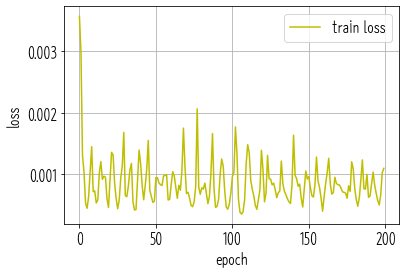

result :  0.006183552090078592


In [8]:

# 5. 모델 학습 과정 표시하기
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 15

fig, loss_ax = plt.subplots()
loss_ax.grid()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper right')
plt.show()
print('result : ', results)

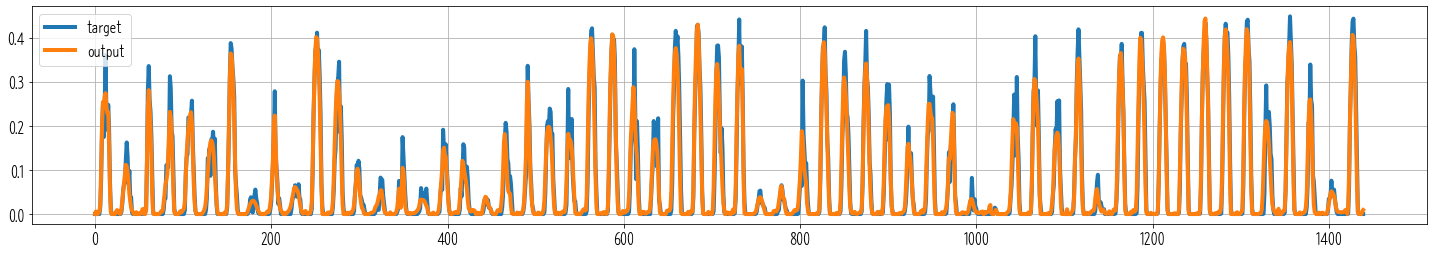

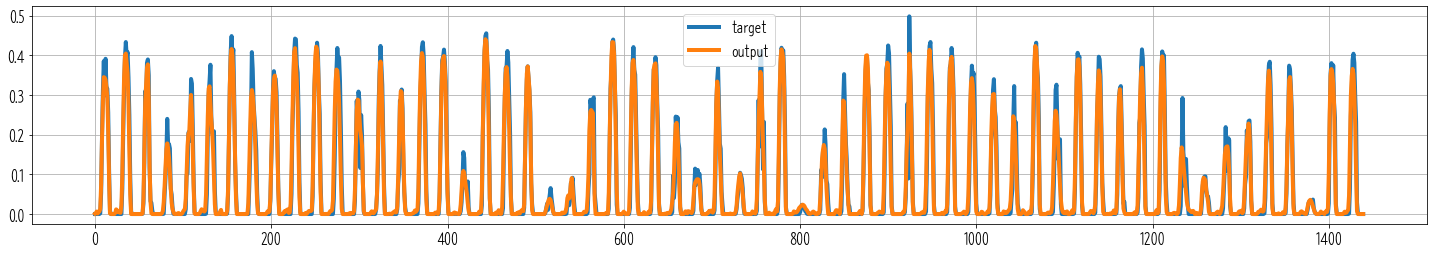

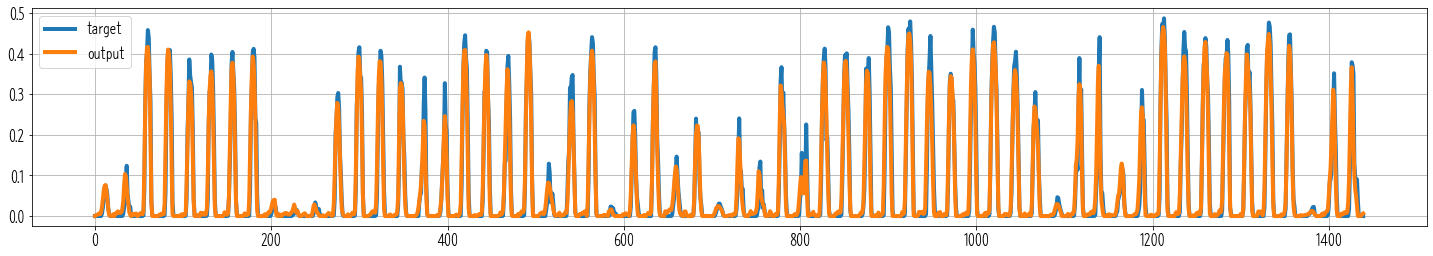

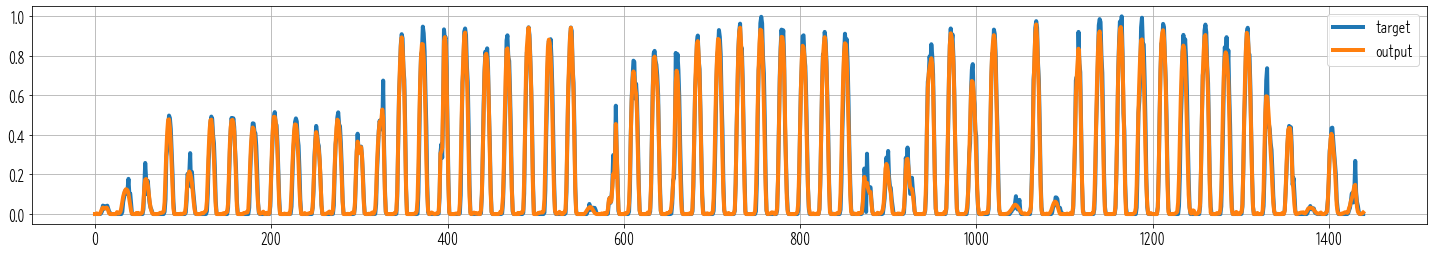

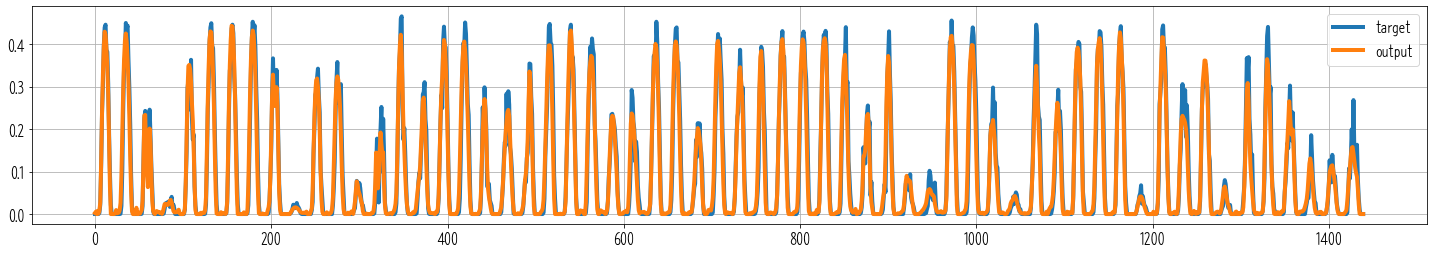

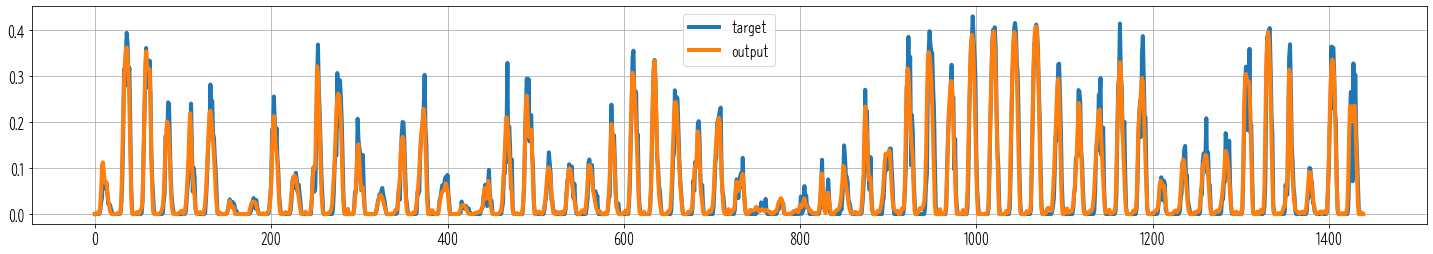

In [9]:
plotY = trainY.reshape(-1,1)
plotY_pred = model.predict(trainX).reshape(-1,1)
plotY_pred[plotY_pred<0] = 0

step = hoursteps*30
for i in range(0, plotY.shape[0]-step, step):
    plt.rcParams["figure.figsize"] = (25,4)
    plt.plot(plotY[i:i+step], label="target",linewidth=4, alpha=1)
    plt.plot(plotY_pred[i:i+step], label="output",linewidth=4, alpha=1)
    #plt.plot(plotY[i:i+step], 'r-', label="target",linewidth=2, alpha=1)
    #plt.plot(plotY_pred[i:i+step], 'y-', label="output",linewidth=2, alpha=1)
    plt.grid()
    plt.legend()
    plt.show()

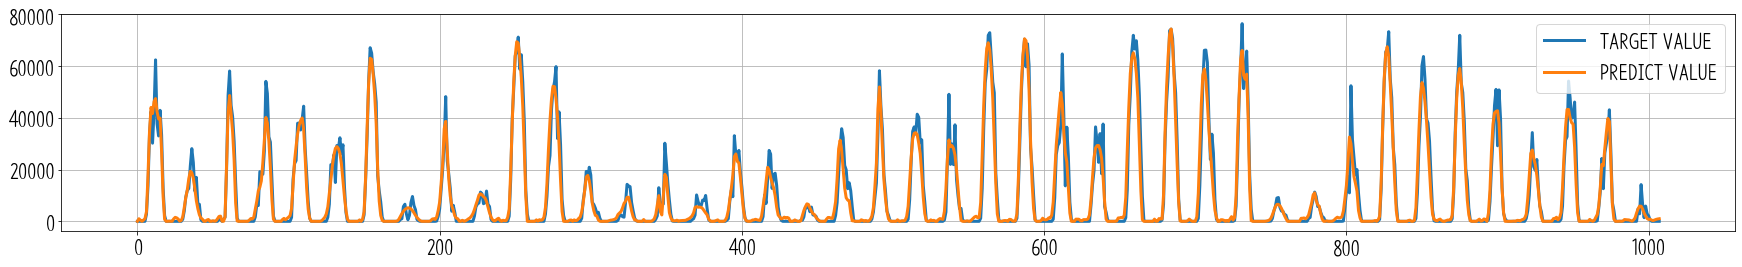

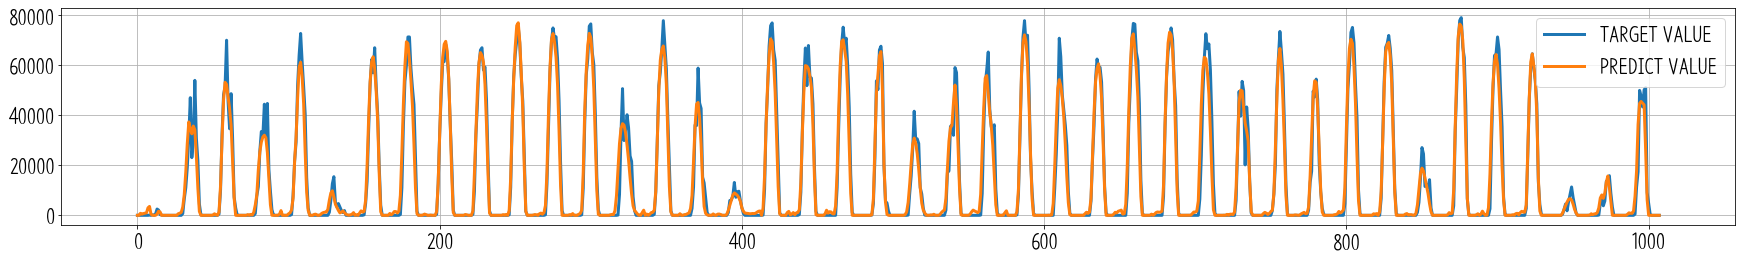

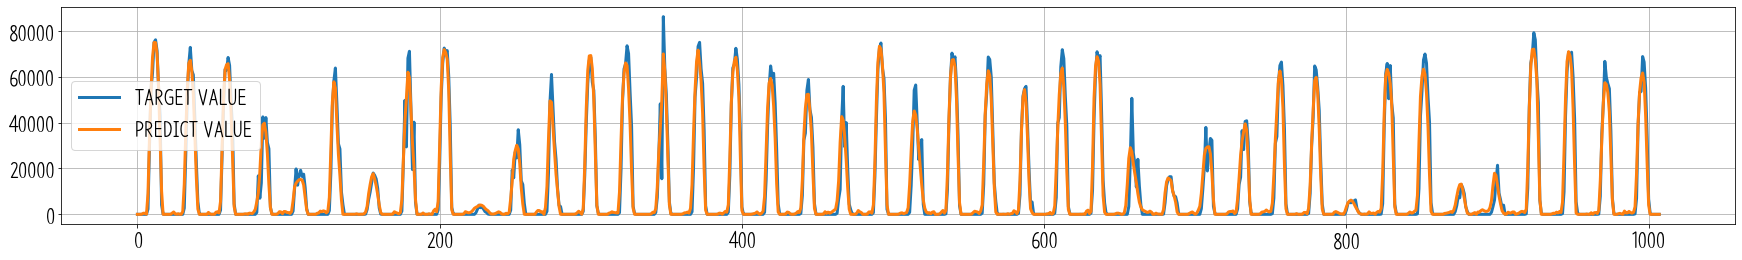

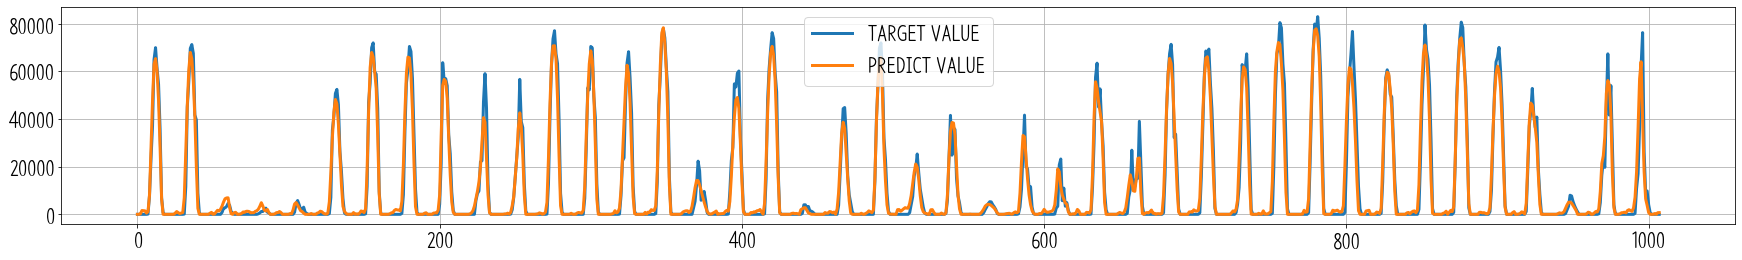

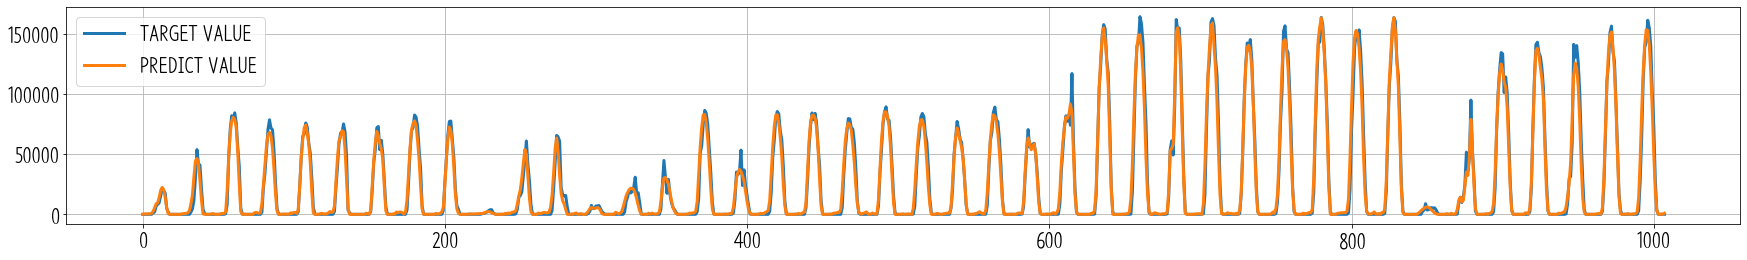

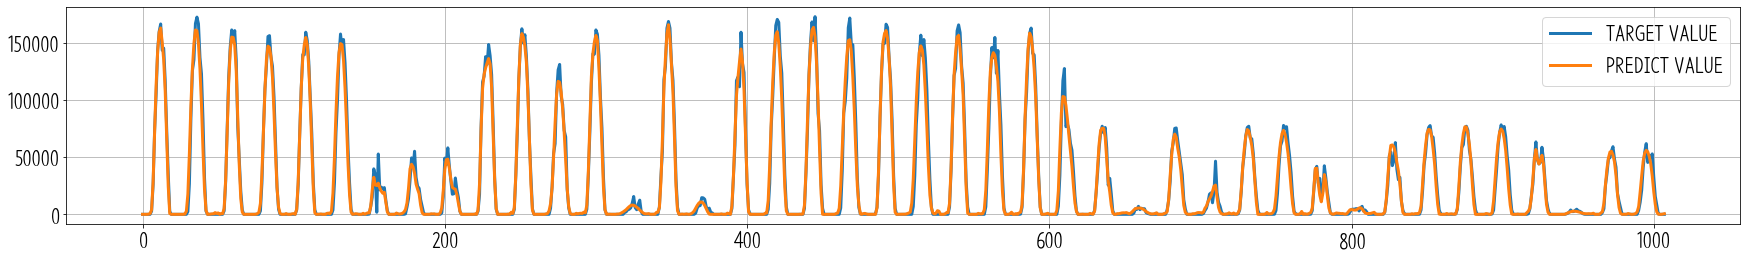

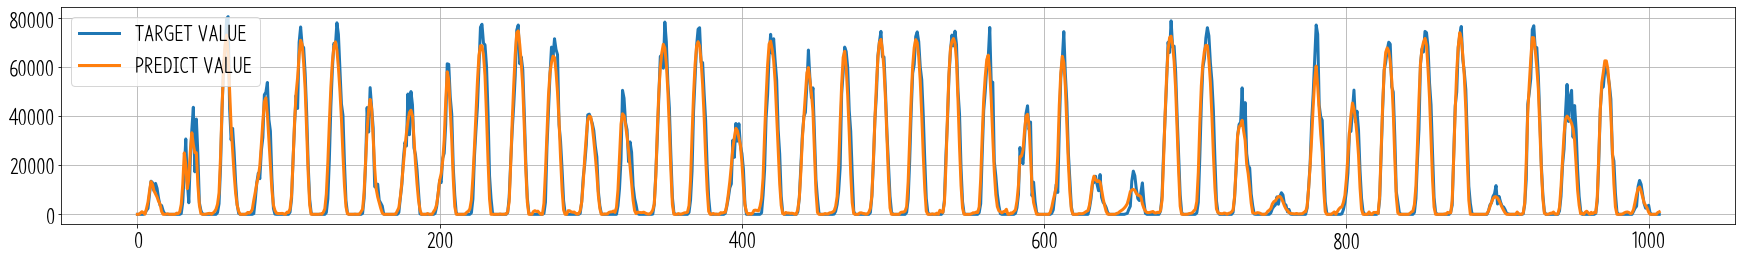

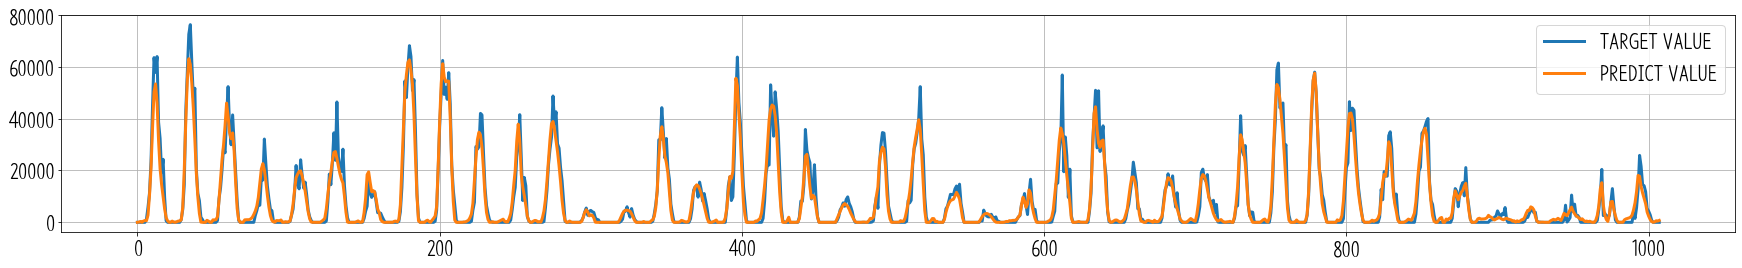

<Figure size 2160x288 with 0 Axes>

In [10]:
plt.rcParams['font.size'] = 20
y = sc_pow.inverse_transform(trainY[:,:,0])
plotY = y.reshape(-1,1)

pred = model.predict(trainX)[:,:,0]
pred[pred<0] = 0

x = sc_pow.inverse_transform(pred)
plotY_pred = x.reshape(-1,1)

acc_list = []
target_list=[]

step = hoursteps*21
for i in range(0, plotY.shape[0]-step, step):
#for i in range(0, plotY.shape[0]-hoursteps, hoursteps):
#for i in range(0, 240-step, step):
    plt.rcParams["figure.figsize"] = (30,4)
    plt.plot(plotY[i:i+step], label="TARGET VALUE",linewidth=3)#,linewidth=4, alpha=0.7)
    plt.plot(plotY_pred[i:i+step],label="PREDICT VALUE",linewidth=3)#,linewidth=2, alpha=1)
    #plt.plot(plotY[i:i+step], 'r-', label="target",linewidth=2, alpha=1)
    #plt.plot(plotY_pred[i:i+step], 'y-', label="output",linewidth=2, alpha=1)
    plt.grid()
    plt.legend()
    plt.show()

#plt.tight_layout()
plt.savefig(save_path+'/predict.jpg')
#plt.show()
#print(plotY_pred)

In [11]:
print(y.shape)
print(y)
print(hoursteps)

(186, 48)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
48


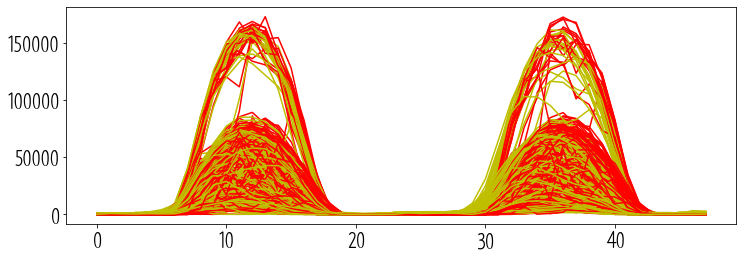

In [11]:
y = sc_pow.inverse_transform(trainY[:,:,0])
plotY = y.reshape(-1,1)

pred = model.predict(trainX)[:,:,0]
pred[pred<0] = 0

x = sc_pow.inverse_transform(pred)
plot_pred = x.reshape(-1,1)

#err_list = []
target_list=[]
predErrRate_list = []

for i in range(0, plotY.shape[0]-hoursteps, hoursteps):
    plt.rcParams["figure.figsize"] = (12,4)
    plt.plot(plotY[i:i+hoursteps], 'r-', label="target")
    plt.plot(plot_pred[i:i+hoursteps], 'y-', label="output")
    #print("******************** i : ", i)
    for hr in range(0, hoursteps):
        pred   = plot_pred[i+hr]
        target = plotY[i+hr]
        difference = np.abs(target-pred)
        predErrRate = np.round(difference/facltyCapacty*100, 2)
        
        #print("|t:",target,"-p:",pred,"|=",err,",예측오차율:",predErrRate)
        #err_list.append(err)
        predErrRate_list.append(predErrRate)
    
    target_list.append(target)
    #acc_list.append(acc_rate)
    #print("   pred: ",pred," | target: ",target," | error: ",error," | err rate: ",error_rate," | acc: ",acc_rate,sep="")

## 시간오차율 (TrainY)

test data :  185.0 일 ( 8880 시간)
mean(err rate): 1.424
 max(err rate): 18.19


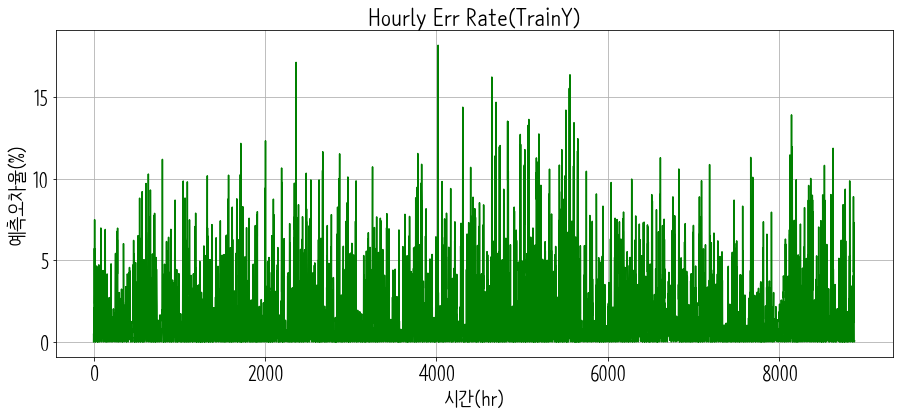

In [12]:
print("test data : ", np.rint(np.shape(predErrRate_list)[0]/hoursteps),"일 (", np.shape(predErrRate_list)[0],"시간)",)
print("mean(err rate): ",np.round(np.mean(predErrRate_list),3),sep='')
print(" max(err rate): ",np.max(predErrRate_list),sep='')

#plotAcc = np.array(acc_list).reshape(-1,1)
plt.rcParams["figure.figsize"] = (15,6)
plt.title("Hourly Err Rate(TrainY)")
plt.xlabel('시간(hr)')
plt.ylabel('예측오차율(%)')
#plt.yticks([0,1,2,3,4,5,6,7,8,9,10])
#plt.ylim(0,10)
plt.plot(predErrRate_list, 'g-')
plt.grid(True)
plt.show()
#print(predErrRate_list)

mean(err rate): 1.448
 max(err rate): 3.4029787234042557


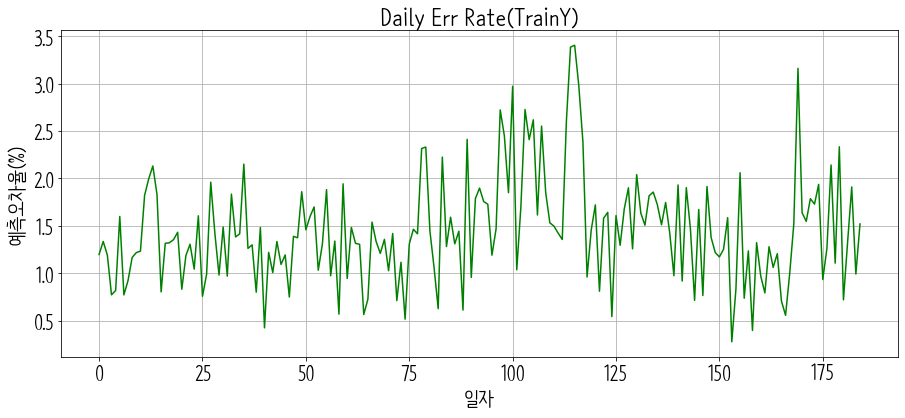

In [13]:
dailyErrRate = []
for i in range(0, plotY.shape[0]-hoursteps, hoursteps):
    dailyErrRate.append(np.mean(predErrRate_list[i:i+hoursteps-1]))

#print(dailyErrRate)    
#print("test data : ", np.rint(np.shape(predErrRate_list)[0]/hoursteps),"일 (", np.shape(predErrRate_list)[0],"시간)",)
print("mean(err rate): ",np.round(np.mean(dailyErrRate),3),sep='')
print(" max(err rate): ",np.max(dailyErrRate),sep='')

#plotAcc = np.array(acc_list).reshape(-1,1)
plt.rcParams["figure.figsize"] = (15,6)
plt.title("Daily Err Rate(TrainY)")
plt.xlabel('일자')
plt.ylabel('예측오차율(%)')
#plt.yticks([0,1,2,3,4,5,6,7,8,9,10])
#plt.ylim(0,10)
plt.plot(dailyErrRate, 'g-')
plt.grid(True)
plt.show()

mean(err rate): 1.101
 max(err rate): 1.5999999999999999


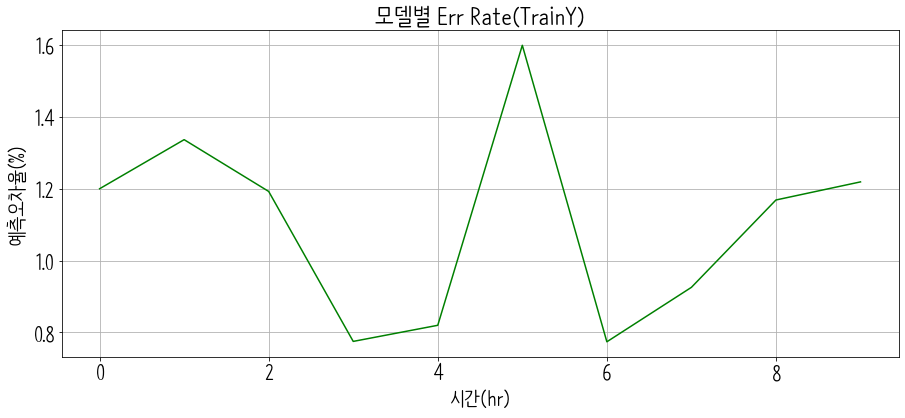

In [14]:
dailyErrRate = []
for m in range(n_model):
    dailyErrRate.append(np.mean(predErrRate_list[hoursteps*m:hoursteps*(m+1)-1]))

#print(dailyErrRate)    
#print("test data : ", np.rint(np.shape(predErrRate_list)[0]/hoursteps),"일 (", np.shape(predErrRate_list)[0],"시간)",)
print("mean(err rate): ",np.round(np.mean(dailyErrRate),3),sep='')
print(" max(err rate): ",np.max(dailyErrRate),sep='')

#plotAcc = np.array(acc_list).reshape(-1,1)
plt.rcParams["figure.figsize"] = (15,6)
plt.title("모델별 Err Rate(TrainY)")
plt.xlabel('시간(hr)')
plt.ylabel('예측오차율(%)')
#plt.yticks([0,1,2,3,4,5,6,7,8,9,10])
#plt.ylim(0,10)
plt.plot(dailyErrRate, 'g-')
plt.grid(True)
plt.show()

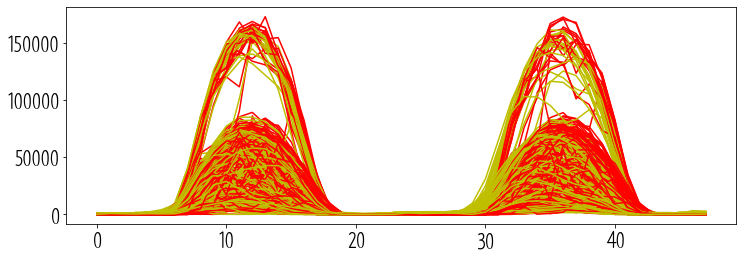

In [15]:
y = sc_pow.inverse_transform(trainY[:,:,0])
plotY = y.reshape(-1,1)

pred = model.predict(trainX)[:,:,0]
pred[pred<0] = 0

x = sc_pow.inverse_transform(pred)
plot_pred = x.reshape(-1,1)

acc_list = []
target_list=[]
predErrRate_list = []

for i in range(0, plotY.shape[0]-hoursteps, hoursteps):
    plt.rcParams["figure.figsize"] = (12,4)
    plt.plot(plotY[i:i+hoursteps], 'r-', label="target")
    plt.plot(plot_pred[i:i+hoursteps], 'y-', label="output")
    #plt.legend()
    #plt.show()
    
    pred = np.sum(plot_pred[i:i+hoursteps])
    target      = round(np.sum(plotY[i:i+hoursteps]), 2)
    
    error       = round(np.abs(target-pred), 2)
    error_rate  = round(error/target, 2)
    acc_rate    = np.max([round((1.0-error_rate)*100, 2),0])
    
    
    predErrRate = round(np.abs((target-pred)/920.2*100), 2)
    predErrRate_list.append(predErrRate)
    
    target_list.append(target)
    acc_list.append(acc_rate)
    #print("   pred: ",pred," | target: ",target," | error: ",error," | err rate: ",error_rate," | acc: ",acc_rate,sep="")

mean(acc rate): 94.6972972972973


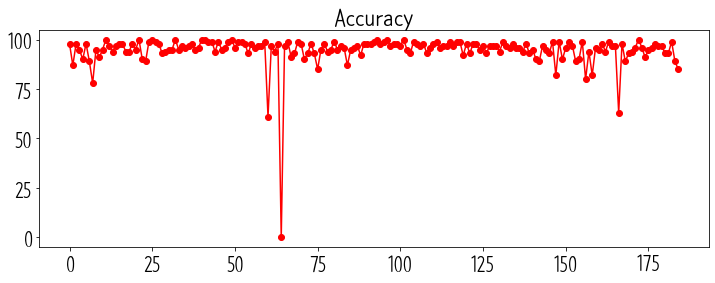

[98.0, 87.0, 98.0, 95.0, 90.0, 98.0, 89.0, 78.0, 95.0, 91.0, 95.0, 100.0, 97.0, 94.0, 97.0, 98.0, 98.0, 94.0, 94.0, 98.0, 95.0, 100.0, 90.0, 89.0, 99.0, 100.0, 99.0, 98.0, 93.0, 94.0, 95.0, 95.0, 100.0, 95.0, 97.0, 96.0, 97.0, 98.0, 95.0, 96.0, 100.0, 100.0, 99.0, 99.0, 94.0, 99.0, 95.0, 96.0, 99.0, 100.0, 96.0, 99.0, 99.0, 98.0, 93.0, 98.0, 96.0, 97.0, 97.0, 99.0, 61.0, 97.0, 94.0, 98.0, 0.0, 97.0, 99.0, 91.0, 93.0, 99.0, 98.0, 90.0, 93.0, 98.0, 93.0, 85.0, 95.0, 98.0, 94.0, 95.0, 99.0, 95.0, 97.0, 96.0, 87.0, 95.0, 96.0, 97.0, 92.0, 98.0, 98.0, 98.0, 99.0, 100.0, 98.0, 99.0, 100.0, 97.0, 98.0, 98.0, 97.0, 100.0, 95.0, 93.0, 99.0, 98.0, 97.0, 98.0, 93.0, 96.0, 98.0, 99.0, 96.0, 97.0, 97.0, 99.0, 97.0, 99.0, 99.0, 92.0, 98.0, 93.0, 98.0, 98.0, 95.0, 97.0, 93.0, 97.0, 97.0, 97.0, 94.0, 99.0, 97.0, 96.0, 98.0, 96.0, 96.0, 94.0, 98.0, 93.0, 95.0, 90.0, 89.0, 97.0, 95.0, 93.0, 99.0, 82.0, 99.0, 90.0, 96.0, 99.0, 97.0, 89.0, 90.0, 99.0, 80.0, 94.0, 82.0, 96.0, 95.0, 98.0, 94.0, 99.0, 97.0, 

In [16]:
print("mean(acc rate): ",np.mean(acc_list),sep='')
    
#plotAcc = np.array(acc_list).reshape(-1,1)
plt.plot(acc_list, 'ro-')
plt.title("Accuracy")
plt.show()
print(acc_list)

# Test dataset

In [17]:

from tensorflow.keras.models import load_model

#get test data
X_test = np.load("npset/"+save_name+"_testX.npy")
y_test = np.load("npset/"+save_name+"_testY.npy")

#get pow scale form
#powdata, scaler = libs_yeon.get_pow()

print("X_test : ", X_test.shape)
print("y_test : ", y_test.shape)

n_dataset   = y_test.shape[0]
acc_list    = []
acc_model   = []
predictModel = []
predErrRate_list_test = []
predList=[]
yList=[]
for i in range(n_model):
    predictModel.append(load_model('model/model_'+save_name+'_'+str(i)+'.h5'))
    acc_model.append(0)
    
print("[ dataset ]")
for m in range(n_model):
#for m in range(2):
    plot_target=[]
    plot_predict=[]
    for i in range(n_dataset):
    #for i in range(5):
    #if(i in [2,3,4,5,6,7,8]): continue;
        y = sc_pow.inverse_transform(y_test[i:i+1,:,0])

        #print("(model",m+1,")\t",end="")

        pred = predictModel[m].predict([X_test[i:i+1]])
        pred[pred<0] = 0
        pred = pred[:,:,0]
        pred = sc_pow.inverse_transform(pred)
        predSum = np.sum(pred)
            
        predList = pred.reshape(-1,1)
        yList = y.reshape(-1,1)
        for hr in range(0, hoursteps):
            predTest   = predList[hr]
            targetTest = yList[hr]
            differenceTest = np.abs(targetTest-predTest)
            predErrRateTest = np.round(differenceTest/facltyCapacty*100, 2)
            plot_target.append(targetTest)
            plot_predict.append(predTest)

            #print("|t:",target,"-p:",pred,"|=",err,",예측오차율:",predErrRate)
            #err_list.append(err)
            predErrRate_list_test.append(predErrRateTest)
        
        target      = round(np.sum(y), 2)
        error       = round(np.abs(target-predSum), 2)
        error_rate  = np.min([round(error/target, 2),1])
        acc_rate    = round((1.0-error_rate)*100, 2)
        acc_list.append(acc_rate)
        acc_model[m] += acc_rate

        #print("   pred: ",pred," | target: ",target," | error: ",error," | err rate: ",error_rate," | acc: ",acc_rate,sep="")
        
    #print("acc rate: ",np.mean(acc_list[-n_model:]),sep='')
    print(np.mean(acc_list[-n_model:]), " / ",sep='', end='')

    # target, predict 비교차트 찍기
    '''
    plt.rcParams['font.size'] = 20
    plt.rcParams["figure.figsize"] = (30,4)
    step_test=hoursteps*10
    for i in range(0, n_dataset, step_test):
        plt.title(str(m)+" Model")
        plt.plot(plot_target[i:i+step_test], label="TARGET VALUE",linewidth=3)#,linewidth=4, alpha=0.7)
        plt.plot(plot_predict[i:i+step_test],label="PREDICT VALUE",linewidth=3)#,linewidth=2, alpha=1)
        plt.grid()
        plt.legend()
        plt.show()
        plt.savefig(save_path+'/predict'+str(i)+'.jpg')
    ''' 
print("\n----------------------------------------------")
print("mean(acc rate): ",np.mean(acc_list),sep='')
print("----------------------------------------------")
print("[ model ]")
for i in range(n_model):
    acc_model[i] = round(acc_model[i]/(n_dataset),2)
    print(acc_model[i])

X_test :  (27, 144, 16)
y_test :  (27, 48, 1)
[ dataset ]
43.2 / 37.7 / 69.0 / 61.5 / 59.9 / 56.4 / 64.3 / 58.2 / 45.3 / 57.7 / 
----------------------------------------------
mean(acc rate): 63.8
----------------------------------------------
[ model ]
55.81
52.67
72.93
69.19
65.74
64.41
66.19
65.26
59.41
66.41


In [ ]:
### 24~48시간 예측치만 ErrRate

In [18]:

from tensorflow.keras.models import load_model

#get test data
X_test = np.load("npset/"+save_name+"_testX.npy")
y_test = np.load("npset/"+save_name+"_testY.npy")

#get pow scale form
#powdata, scaler = libs_yeon.get_pow()

print("X_test : ", X_test.shape)
print("y_test : ", y_test.shape)

n_dataset   = y_test.shape[0]
acc_list    = []
acc_model   = []
predictModel = []
predErrRate_list_test = []
predList=[]
yList=[]
for i in range(n_model):
    predictModel.append(load_model('model/model_'+save_name+'_'+str(i)+'.h5'))
    acc_model.append(0)
    
print("[ dataset ]")
for m in range(n_model):
#for m in range(2):
    plot_target=[]
    plot_predict=[]
    for i in range(n_dataset):
    #for i in range(5):
    #if(i in [2,3,4,5,6,7,8]): continue;
        y = sc_pow.inverse_transform(y_test[i:i+1,:,0])

        #print("(model",m+1,")\t",end="")

        pred = predictModel[m].predict([X_test[i:i+1]])
        pred[pred<0] = 0
        pred = pred[:,:,0]
        pred = sc_pow.inverse_transform(pred)
        predSum = np.sum(pred)
            
        predList = pred.reshape(-1,1)
        yList = y.reshape(-1,1)
        for hr in range(24, hoursteps):
            predTest   = predList[hr]
            targetTest = yList[hr]
            differenceTest = np.abs(targetTest-predTest)
            predErrRateTest = np.round(differenceTest/facltyCapacty*100, 2)
            plot_target.append(targetTest)
            plot_predict.append(predTest)

            #print("|t:",target,"-p:",pred,"|=",err,",예측오차율:",predErrRate)
            #err_list.append(err)
            predErrRate_list_test.append(predErrRateTest)
        
        target      = round(np.sum(y), 2)
        error       = round(np.abs(target-predSum), 2)
        error_rate  = np.min([round(error/target, 2),1])
        acc_rate    = round((1.0-error_rate)*100, 2)
        acc_list.append(acc_rate)
        acc_model[m] += acc_rate

        #print("   pred: ",pred," | target: ",target," | error: ",error," | err rate: ",error_rate," | acc: ",acc_rate,sep="")
        
    #print("acc rate: ",np.mean(acc_list[-n_model:]),sep='')
    print(np.mean(acc_list[-n_model:]), " / ",sep='', end='')

    # target, predict 비교차트 찍기
    '''
    plt.rcParams['font.size'] = 20
    plt.rcParams["figure.figsize"] = (30,4)
    step_test=hoursteps*10
    for i in range(0, n_dataset, step_test):
        plt.title(str(m)+" Model")
        plt.plot(plot_target[i:i+step_test], label="TARGET VALUE",linewidth=3)#,linewidth=4, alpha=0.7)
        plt.plot(plot_predict[i:i+step_test],label="PREDICT VALUE",linewidth=3)#,linewidth=2, alpha=1)
        plt.grid()
        plt.legend()
        plt.show()
        plt.savefig(save_path+'/predict'+str(i)+'.jpg')
    ''' 
print("\n----------------------------------------------")
print("mean(acc rate): ",np.mean(acc_list),sep='')
print("----------------------------------------------")
print("[ model ]")
for i in range(n_model):
    acc_model[i] = round(acc_model[i]/(n_dataset),2)
    print(acc_model[i])

X_test :  (27, 144, 16)
y_test :  (27, 48, 1)
[ dataset ]
43.2 / 37.7 / 69.0 / 61.5 / 59.9 / 56.4 / 64.3 / 58.2 / 45.3 / 57.7 / 
----------------------------------------------
mean(acc rate): 63.8
----------------------------------------------
[ model ]
55.81
52.67
72.93
69.19
65.74
64.41
66.19
65.26
59.41
66.41


In [82]:
plot_target.shape

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
### 0~48시간 예측치 ErrRate

In [23]:

from tensorflow.keras.models import load_model

#get test data
X_test = np.load("npset/"+save_name+"_testX.npy")
y_test = np.load("npset/"+save_name+"_testY.npy")

#get pow scale form
#powdata, scaler = libs_yeon.get_pow()

print("X_test : ", X_test.shape)
print("y_test : ", y_test.shape)

n_dataset   = y_test.shape[0]
acc_list    = []
acc_model   = []
predictModel = []
predErrRate_list_test = []

for i in range(n_model):
    predictModel.append(load_model('model/model_'+save_name+'_'+str(i)+'.h5'))
    acc_model.append(0)
    
print("[ dataset ]")
for i in range(n_dataset):
    #if(i in [2,3,4,5,6,7,8]): continue;
    y = sc_pow.inverse_transform(y_test[i:i+1,:,0])

    for m in range(n_model):
        #print("(model",m+1,")\t",end="")

        pred = predictModel[m].predict([X_test[i:i+1]])
        pred[pred<0] = 0
        pred = pred[:,:,0]
        pred = sc_pow.inverse_transform(pred)
        predSum = np.sum(pred)
            
        # target, predict 비교차트 찍기
#         plt.rcParams['font.size'] = 20
#         plt.rcParams["figure.figsize"] = (30,4)
#         plotTestY = y.reshape(-1,1)
#         plotTestY_pred = pred.reshape(-1,1)
#         plt.title(str(m)+" Model")
#         plt.plot(plotTestY[0:hoursteps], label="TARGET VALUE",linewidth=3)#,linewidth=4, alpha=0.7)
#         plt.plot(plotTestY_pred[0:hoursteps],label="PREDICT VALUE",linewidth=3)#,linewidth=2, alpha=1)
#         plt.grid()
#         plt.legend()
#         plt.show()
#         plt.savefig(save_path+'/predict'+str(i)+'.jpg')

        
        predList = pred.reshape(-1,1)
        yList = y.reshape(-1,1)
        for hr in range(0, hoursteps):
            predTest   = predList[hr]
            targetTest = yList[hr]
            differenceTest = np.abs(targetTest-predTest)
            predErrRateTest = np.round(differenceTest/facltyCapacty*100, 2)

            #print("|t:",target,"-p:",pred,"|=",err,",예측오차율:",predErrRate)
            #err_list.append(err)
            predErrRate_list_test.append(predErrRateTest)
        
        target      = round(np.sum(y), 2)
        error       = round(np.abs(target-predSum), 2)
        error_rate  = np.min([round(error/target, 2),1])
        acc_rate    = round((1.0-error_rate)*100, 2)
        acc_list.append(acc_rate)
        acc_model[m] += acc_rate
                 
        #print("   pred: ",pred," | target: ",target," | error: ",error," | err rate: ",error_rate," | acc: ",acc_rate,sep="")
        
    #print("acc rate: ",np.mean(acc_list[-n_model:]),sep='')
    print(np.mean(acc_list[-n_model:]), " / ",sep='', end='')
        
print("\n----------------------------------------------")
print("mean(acc rate): ",np.mean(acc_list),sep='')
print("----------------------------------------------")
print("[ model ]")
for i in range(n_model):
    acc_model[i] = round(acc_model[i]/(n_dataset),2)
    print(acc_model[i])

X_test :  (27, 144, 16)
y_test :  (27, 48, 1)
[ dataset ]
82.5 / 87.1 / 59.0 / 72.2 / 79.3 / 73.6 / 75.6 / 58.2 / 58.8 / 39.7 / 73.9 / 82.9 / 0.8 / 61.7 / 86.1 / 91.3 / 86.7 / 70.9 / 62.7 / 32.5 / 46.8 / 90.0 / 68.6 / 89.8 / 7.4 / 84.5 / 0.0 / 
----------------------------------------------
mean(acc rate): 63.8
----------------------------------------------
[ model ]
55.81
52.67
72.93
69.19
65.74
64.41
66.19
65.26
59.41
66.41


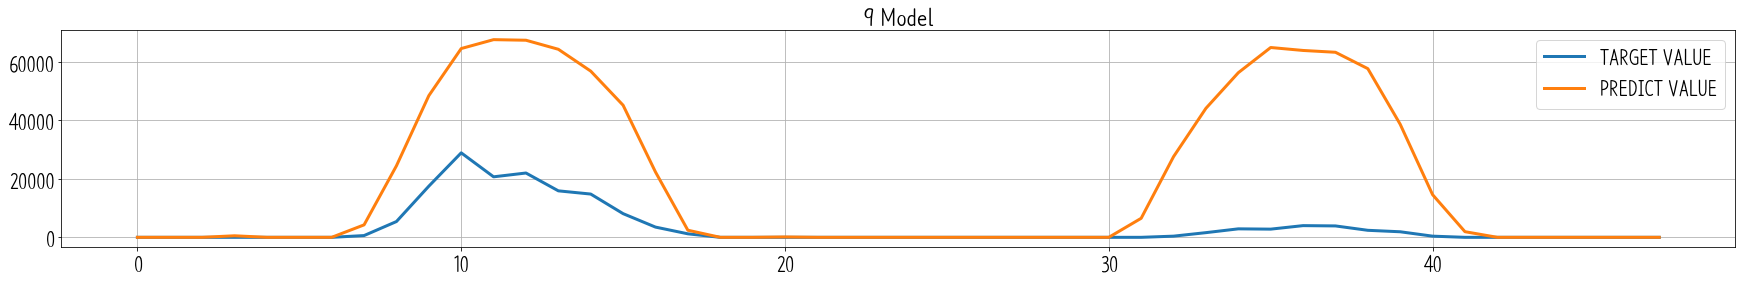

<Figure size 2160x288 with 0 Axes>

In [22]:
plt.rcParams['font.size'] = 20
plt.rcParams["figure.figsize"] = (30,4)
plotTestY = y.reshape(-1,1)
plotTestY_pred = pred.reshape(-1,1)
plt.title(str(m)+" Model")
plt.plot(plotTestY[0:hoursteps], label="TARGET VALUE",linewidth=3)#,linewidth=4, alpha=0.7)
plt.plot(plotTestY_pred[0:hoursteps],label="PREDICT VALUE",linewidth=3)#,linewidth=2, alpha=1)
plt.grid()
plt.legend()
plt.show()
plt.savefig(save_path+'/predict'+str(i)+'.jpg')

test data :  270.0 일 ( 12960 시간)
mean(err rate): 4.15
 max(err rate): 38.37


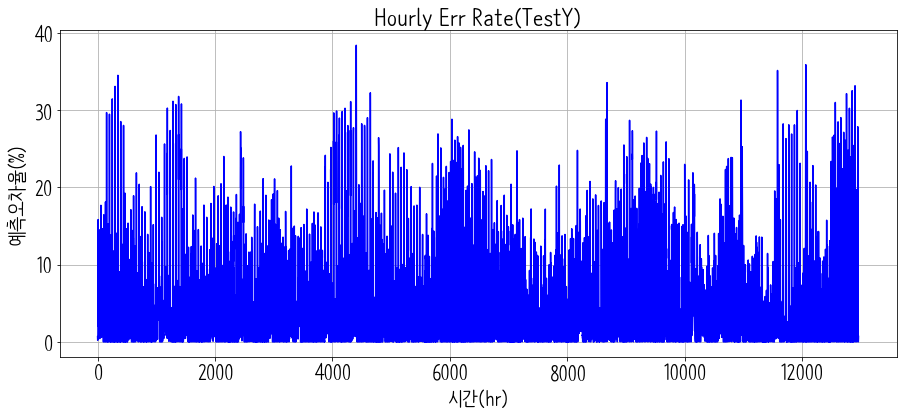

In [24]:
print("test data : ", np.rint(np.shape(predErrRate_list_test)[0]/hoursteps),"일 (", np.shape(predErrRate_list_test)[0],"시간)",)
print("mean(err rate): ",np.round(np.mean(predErrRate_list_test),3),sep='')
print(" max(err rate): ",np.max(predErrRate_list_test),sep='')

#plotAcc = np.array(acc_list).reshape(-1,1)
plt.rcParams["figure.figsize"] = (15,6)
plt.title("Hourly Err Rate(TestY)")
plt.xlabel('시간(hr)')
plt.ylabel('예측오차율(%)')
#plt.yticks([0,1,2,3,4,5,6,7,8,9,10])
#plt.ylim(0,10)
plt.plot(predErrRate_list_test, 'b-')
plt.grid(True)
plt.show()
#print(predErrRate_list)

mean(err rate): 4.026
 max(err rate): 9.956170212765958


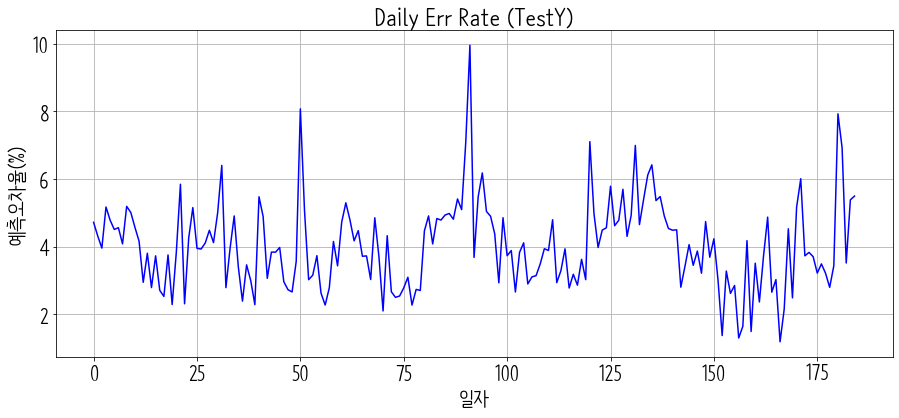

In [25]:
dailyErrRate_test = []
for i in range(0, plotY.shape[0]-hoursteps, hoursteps):
    dailyErrRate_test.append(np.mean(predErrRate_list_test[i:i+hoursteps-1]))

#print(dailyErrRate)    
#print("test data : ", np.rint(np.shape(predErrRate_list)[0]/hoursteps),"일 (", np.shape(predErrRate_list)[0],"시간)",)
print("mean(err rate): ",np.round(np.mean(dailyErrRate_test),3),sep='')
print(" max(err rate): ",np.max(dailyErrRate_test),sep='')

#plotAcc = np.array(acc_list).reshape(-1,1)
plt.rcParams["figure.figsize"] = (15,6)
plt.title("Daily Err Rate (TestY)")
plt.xlabel('일자')
plt.ylabel('예측오차율(%)')
#plt.yticks([0,1,2,3,4,5,6,7,8,9,10])
#plt.ylim(0,10)
plt.plot(dailyErrRate_test, 'b-')
plt.grid(True)
plt.show()

mean(err rate): 1.441
 max(err rate): 1.7806666666666664


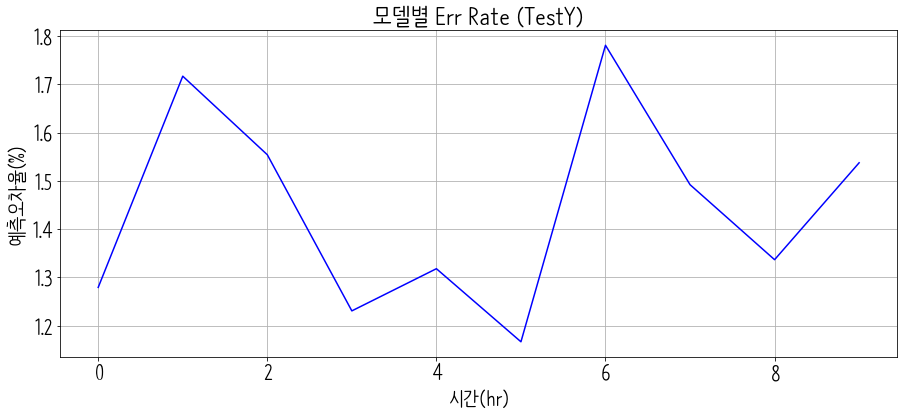

In [64]:
dailyErrRate_test = []
for m in range(n_model):
    dailyErrRate_test.append(np.mean(predErrRate_list_test[hoursteps*m:hoursteps*(m+1)-1]))
    
#print(dailyErrRate_test)    
#print("test data : ", np.rint(np.shape(predErrRate_list)[0]/hoursteps),"일 (", np.shape(predErrRate_list)[0],"시간)",)
print("mean(err rate): ",np.round(np.mean(dailyErrRate_test),3),sep='')
print(" max(err rate): ",np.max(dailyErrRate_test),sep='')

#plotAcc = np.array(acc_list).reshape(-1,1)
plt.rcParams["figure.figsize"] = (15,6)
plt.title("모델별 Err Rate (TestY)")
plt.xlabel('시간(hr)')
plt.ylabel('예측오차율(%)')
#plt.yticks([0,1,2,3,4,5,6,7,8,9,10])
#plt.ylim(0,10)
plt.plot(dailyErrRate_test, 'b-')
plt.grid(True)
plt.show()

In [41]:
print(hoursteps)
for i in range(n_dataset):
    #if(i in [2,3,4,5,6,7,8]): continue;
    print("--------------------------------------------------[",i,"dataset]")
    for m in range(n_model):
        startidx=i*n_model*hoursteps
        print(m, "model: ", np.mean(predErrRate_list_test[startidx+hoursteps*m:startidx+hoursteps*(m+1)-1]))#39.65
    
    
#predErrRate_listTest[]    

16
--------------------------------------------------[ 0 dataset]
0 model:  1.2793333333333332
1 model:  1.716666666666667
2 model:  1.5539999999999998
3 model:  1.2306666666666668
4 model:  1.318
5 model:  1.1666666666666667
6 model:  1.7806666666666664
7 model:  1.492
8 model:  1.3366666666666667
9 model:  1.5373333333333332
--------------------------------------------------[ 1 dataset]
0 model:  1.4853333333333334
1 model:  3.3280000000000007
2 model:  1.582
3 model:  1.8106666666666669
4 model:  1.6793333333333331
5 model:  1.3846666666666667
6 model:  2.313333333333333
7 model:  2.223333333333333
8 model:  1.824
9 model:  2.525333333333333
--------------------------------------------------[ 2 dataset]
0 model:  1.232
1 model:  3.8759999999999994
2 model:  2.442
3 model:  2.8033333333333337
4 model:  2.735333333333334
5 model:  2.1839999999999997
6 model:  2.3526666666666665
7 model:  2.365333333333333
8 model:  2.181333333333334
9 model:  2.785333333333333
------------------------

In [35]:
print(hoursteps)
#for i in range(n_dataset):
    #if(i in [2,3,4,5,6,7,8]): continue;
for m in range(n_model):
    print(m, " : ", np.sum(predErrRate_listTest[hoursteps*m:hoursteps*(m+1)-1]))#39.65

    
#predErrRate_listTest[]    

16
0  :  19.189999999999998
1  :  25.750000000000004
2  :  23.31
3  :  18.46
4  :  19.77
5  :  17.5
6  :  26.709999999999997
7  :  22.38
8  :  20.05
9  :  23.06


In [17]:
print(pred.shape)

(1, 16)


In [18]:
## 시간오차율 (TestY)

test data :  550.0 일 ( 8800 시간)
mean(err rate): 2.583
 max(err rate): 24.79


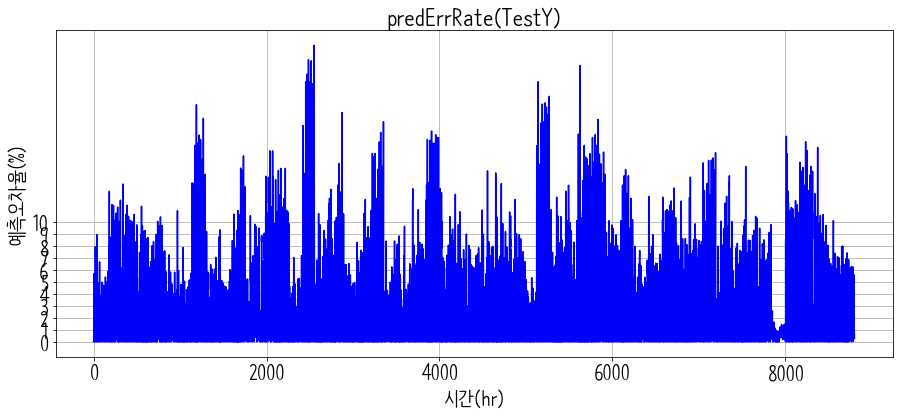

In [19]:
print("test data : ", np.rint(np.shape(predErrRate_listTest)[0]/hoursteps),"일 (", np.shape(predErrRate_listTest)[0],"시간)",)
print("mean(err rate): ",np.round(np.mean(predErrRate_listTest),3),sep='')
print(" max(err rate): ",np.max(predErrRate_listTest),sep='')

#plotAcc = np.array(acc_list).reshape(-1,1)
plt.rcParams["figure.figsize"] = (15,6)
plt.title("predErrRate(TestY)")
plt.xlabel('시간(hr)')
plt.ylabel('예측오차율(%)')
plt.yticks([0,1,2,3,4,5,6,7,8,9,10])
#plt.ylim(0,10)
plt.plot(predErrRate_listTest, 'b-')
plt.grid(True)
plt.show()
#print(predErrRate_list)